## Stim-coding vs. Accuracy-coding for within-subject design


Issues need to be solved:
* Add more than $v$ to the model;
* Stim-coding with HDDMRegression (there was a tutorial on this)
* Flexible design


The distinction between stimulus coding and accuracy coding is quit obscure to me. 

First, how should we code the "response" column? As the real response (left vs, right) or as accuracy? In the HDDMStimCoding's script, it writes "HDDM model that can be used when stimulus coding and estimation of bias (i.e. displacement of starting point z) is required. In that case, **the 'resp' column in your data should contain 0 and 1 for the chosen stimulus (or direction), not whether the response was correct or not as you would use in accuracy coding**. You then have to provide another column (referred to as stim_col) which contains information about which the correct response was." In this case, should options of response column be the same as the "stim_col"? 

But, in the tutorial about stimcoding with regression, the resp column is accuracy coding: ".... Rather, we want to measure response-bias (in favor of face or house) while assuming the same drift rate for both stimuli. We can achieve this for **accuracy coded data** by modeling the bias as moved towards the correct response boundary for one stimulus (e.g. z = .6 for houses) and away from the correct response boundary for the other stimulus (1-z = .4 for faces)."

Second, when should we use stimulus-coding? Only when we assume that the response doesn't interact with another variable, or only when they interact in a particular way? In the simulation of stimulus coding with regression, we either assume the $v$ is the same or the $v$ has same absolute value but with different sign. Essencially , the assumption here is that response to either direction doesn't matter so match. This assumpation usually holds in some tasks, e.g., the random-dot paradigm, where response to left or right doesn't really matter. But for other experimental design, the responses themselves are meaningful. For example, response to left and right means to different stimuli, instead of the same stimuli with different direction. In this case, it seems to that we should not use the stimuli coding.

Third, in the case mentioned above, can we use stimcoding and put the response direction as a factor in the depends_on?

Forth, is regressor model really more powerful, or better for within design? There was an unsolved thread about the fitting: https://groups.google.com/g/hddm-users/c/6EkEMRyC6co/m/G56a2NgwCgAJ. The issues never mentioned include power and simple size?

Fifth,multiple combination of parameters can generate same behavioral patterns (RT & ACC)? But these different combinations of parameter be detected by DDM? Lerche & Voss (2020, Quantitative Methods for Psychology) proposed that RT and ACC and be misleading, but them didn't compare the difference between different models, e.g., using confussion matrix as proposed by Collins & Wilson (2019).

Note: here I only discuss the within-subject design, which may need to use the regressor module of HDDM.

In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current Python version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython, kabuki, pymc
import numpy as np
import pandas as pd
import seaborn as sns
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current Kabuki version is', kabuki.__version__) # 0.6.3
print('The current PyMC version is', pymc.__version__) # 2.3.8

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
print('The current IPython version is', IPython.__version__) 

print('The current Numpy version is', np.__version__) 

print('The current Pandas version is', pd.__version__)

print('The current seaborn version is', sns.__version__)

Notebook is running: /home/hcp4715/miniconda3/envs/hddm/bin/python
The current Python version is 3.7.7
The current HDDM version is 0.8.0
The current Kabuki version is 0.6.3
The current PyMC version is 2.3.8
The current IPython version is 7.13.0
The current Numpy version is 1.18.5
The current Pandas version is 1.0.4
The current seaborn version is 0.10.1


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
%matplotlib inline

# Preparation
import os, time, csv
from datetime import date
import random

import kabuki, hddm
from patsy import dmatrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Example 1: Stituation can use stimcoding

This example can be found [here](http://ski.clps.brown.edu/hddm_docs/tutorial_regression_stimcoding.html).

The problem with this set up is that the simulated results is different from what we observed from the self-tagging task. More specifically, in the self-tagging task, usually there is no sig difference between different condition for the non-matching task, but there is sig differences between different conditions for the matching task.

In [3]:
# # set number of subjects and number of trials per level for the simulated experiment
# n_subjects = 30
# trials_per_level = 100

# # Next, set up parameters of the DDM for three levels and the first stimulus. 
# level1a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
# level2a = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
# level3a = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}

# # Next, set up parameters for the second stimulus, where `v` is the different as for the first stimulus. 
# # and `z(stimulus_b) = 1 - z(stimulus_a)`. 
# level1b = {'v':.3, 'a':2, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}
# level2b = {'v':.4, 'a':2, 't':.3,'sv': 0, 'z':.4, 'sz': 0, 'st': 0}
# level3b = {'v':.5, 'a':2, 't':.3,'sv': 0, 'z':.3, 'sz': 0, 'st': 0}

# random.seed(123)
# np.random.seed(123)
# data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
#                                                 'level2': level2a,
#                                                 'level3': level3a},
#                                               size=trials_per_level,
#                                               subjs=n_subjects)

# data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
#                                                 'level2': level2b,
#                                                 'level3': level3b},
#                                               size=trials_per_level,
#                                               subjs=n_subjects)

# # combine the data from two conditions
# data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # a = left
# data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*2, index=data_a.index) # b = right
# mydata = data_a.append(data_b,ignore_index=True)

# # Write a short function to transform the params_a into a dataframe for later use.
# # params_a is a dict of lists of dicts

# # type(params_a) # dict
# # type(params_a['level1']) # list
# # type(params_a['level1'][1]) # dict

# # rows list initialization 
# #rows = [] 
# cols = ['condition', 'subj_idx', 'params', 'value']
# row = []
# df_params_a = pd.DataFrame([], columns = cols)
# #

# for level in params_a.keys(): 
#     data_row = params_a[level]

#     for subj, data in enumerate(data_row):

#         for key, value in data.items():
#             #row.append(level)
#             #row.append(subj)
#             #row.append(key)
#             #row.append(value)
#             row = [[level, subj, key, value]]
#             data = pd.DataFrame(row, columns=cols)
#             df_params_a = df_params_a.append(data, ignore_index=True)
            

# df_params_a = df_params_a.pivot_table(index = ['condition','subj_idx'], columns =['params'], 
#                         values =['value']).reset_index() 

# col_ind = ['condition','subj_idx', 'a_pop', 'st_pop','sv_pop', 'sz_pop', 't_pop', 'v_pop', 'z_pop']
# df_params_a.columns = col_ind

# df_params_a['StimType'] = 'left'

# df_params_a.head()

# cols = ['condition', 'subj_idx', 'params', 'value']
# row = []
# df_params_b = pd.DataFrame([], columns = cols)
# #

# for level in params_b.keys(): 
#     data_row = params_b[level]

#     for subj, data in enumerate(data_row):

#         for key, value in data.items():
#             row = [[level, subj, key, value]]
#             data = pd.DataFrame(row, columns=cols)
#             df_params_b = df_params_b.append(data, ignore_index=True)
            

# df_params_b = df_params_b.pivot_table(index = ['condition','subj_idx'], columns =['params'], 
#                         values =['value']).reset_index() 

# col_ind = ['condition','subj_idx', 'a_pop', 'st_pop','sv_pop', 'sz_pop', 't_pop', 'v_pop', 'z_pop']
# df_params_b.columns = col_ind

# df_params_b['StimType'] = 'right'

# df_params_b.head()

# df_params = pd.concat([df_params_a, df_params_b])
# df_params.head()

,condition,subj_idx,a_pop,st_pop,sv_pop,sz_pop,t_pop,v_pop,z_pop,StimType
0,level1,0,2.099735,0.149139,0.165144,0.126594,0.328298,0.191437,0.257332,left
1,level1,1,2.031158,0.126082,0.075203,0.092958,0.285795,0.236110,0.506964,left
2,level1,2,1.922423,0.065015,0.010147,0.047277,0.417806,0.433745,0.457832,left
3,level1,3,1.972896,0.050523,0.072614,0.074176,0.360417,0.322253,0.599803,left
4,level1,4,1.898836,0.106391,0.101162,0.101349,0.384433,0.222342,0.712582,left


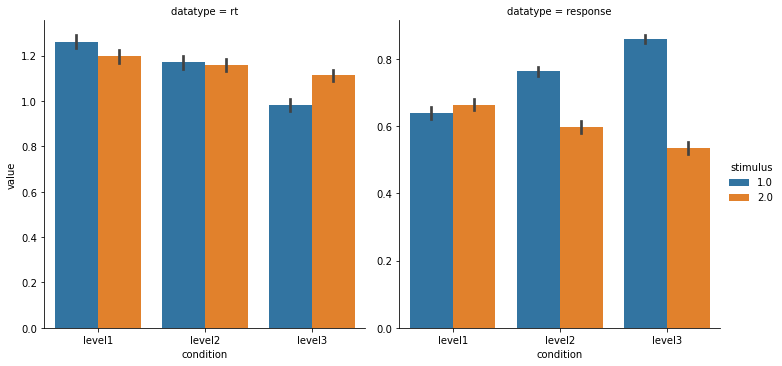

In [4]:
# ## plot the RT and Accuracy

# # wide-to-long format
# df_plot = pd.melt(mydata, 
#                   id_vars=['subj_idx', 'condition','stimulus'], 
#                   value_vars=['rt', 'response'],
#                   var_name='datatype')
# # df_plot.head()

# # way 1: 
# # stim_ord = df_plot.stimulus.unique()
# # g = sns.FacetGrid(df_plot, col="datatype", 
# #                  sharex=False,
# #                   sharey=False,
# #                  height=4)
# # g.map(sns.barplot, "condition", "value",'stimulus', hue_order=np.unique(df_plot["stimulus"]))

# # Way 2: 
# g = sns.catplot(data=df_plot, x='condition', y='value', hue='stimulus', col='datatype', kind='bar',
#                sharex=False, sharey=False)

### Example 2: Very similar case but response direction are meaningful

In this case, we actually have 2 * 3 design, the first factor is concening the stimulus type, and linked to different response. In this case, there is a strong interaction between the two factors, and for the condition B, there is no sig differences between the three levels, either in RT or ACC, but in condition A, there is sig diff. 

Let's assume the ground true of the model parameter is as below:

Parameter for condation A:

level1a = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level2a = {'v':1.6, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}

level3a = {'v':2.0, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

Parameter for condation B:

level1b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level2b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level3b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

How can we model the simulated data?

There are multiple ways:

#### Accuracy-coding + HDDM
That is, we treat the data as accuracy-coding and use the base function. The pseudo code is like:

m1 = hddm:HDDM(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]}, ...)

#### Stim-coding + HDDMstimcoding
That is, we treat the data as stimulus-coding and use the base function. But in this stituation, we might have two way to define the model.

The first way is treating the stimulus doesn't matter, as assumed by the stimcoding, the pseudo code is like:

m2 = hddm:HDDMStimcoding(depends_on = {'v': [levels], 'z':[levels]}, ...)


* Note However, in this case, the result will estimate the `v` and `z` at three levels instead 2 by 3 conditions, which means it didn't have big chance to recover the original six parameters.


The second way is treating the stimulus matters and add stimu as an addition factor, the pseudo code is like:

m3 = hddm:HDDMStimcoding(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]})

#### Accuracy-coding + regressor
That is, we treat the data as accuracy-coding with within-subject design. The pseudo code is like:

m4 = hddm:HDDMRegressor{ 'v' ~ Stim * levels, 'z' ~ stim * levels, link:lamda invlogit_without_multiplying_sim}

#### Stim-coding + regressor
That is, we treat the data as stimulus-coding with within-subject design. And, again, we have two ways to model this situation. 

The first is assume that the data satify the assumption of stim-coding, and not model the stimuli type. The pseudo code is like:

m5 = hddm:HDDMRegressor{ 'v' ~ levels, 'z' ~ levels, link:lamda invlogit_multiplying_sim}

* Note this model is also problematic as m2

Alternatively, we assume the data do not satfifying the model assumption, the pseudo code is like:

m6 = hddm:HDDMRegressor{ 'v' ~ stim * levels, 'z' ~ stim * levels, link:lamda invlogit_multiplying_sim}.

### Steps for stimulation:

Step 1: simulate the data

Step 2: check the data itself

Step 3: fit the data with six models mentioned above

Step 4: Compare the models' DIC and PPC

Step 5: Conclusion and recommendataion

### Step 1: Generate simulation data

Generate the data


In [3]:
# set number of subjects and number of trials per level for the simulated experiment
n_subjects = 30
trials_per_level = 60

# Next, set up parameters of the DDM for three levels and the first stimulus. 
level1a = {'v':1.5, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level2a = {'v':1.6, 'a':1.3, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level3a = {'v':2.0, 'a':1.3, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

# Next, set up parameters for the second stimulus, where `v` is the different as for the first stimulus. 
# and `z(stimulus_b) = 1 - z(stimulus_a)`. 
level1b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level2b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level3b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

Generate data, using the same parameters but assume the it's all within-subject.

In [4]:
random.seed(123)
np.random.seed(123)

mydata, params = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a,
                                                'level4': level1b,
                                                'level5': level2b,
                                                'level6': level3b},
                                              size=trials_per_level,
                                              subjs=n_subjects)

mydata['stimulus'] = np.where(((mydata['condition'] == 'level1') |
                              (mydata['condition'] == 'level2') |
                              (mydata['condition'] == 'level3')) , 1, 2)

mydata.loc[(mydata['condition'] == 'level4'),'condition']= 'level1'
mydata.loc[(mydata['condition'] == 'level5'),'condition']= 'level2'
mydata.loc[(mydata['condition'] == 'level6'),'condition']= 'level3'

# print('Unique combinations of levels and stimulus')
# mydata.groupby(['condition','stimulus']).size()

# covert the params into dataframe for later use.
cols = ['condition', 'subj_idx', 'params', 'value']
row = []
df_params = pd.DataFrame([], columns = cols)
#

for level in params.keys(): 
    data_row = params[level]

    for subj, data in enumerate(data_row):

        for key, value in data.items():
            row = [[level, subj, key, value]]
            data = pd.DataFrame(row, columns=cols)
            df_params = df_params.append(data, ignore_index=True)
            

df_params = df_params.pivot_table(index = ['condition','subj_idx'], columns =['params'], 
                        values =['value']).reset_index() 

col_ind = ['condition','subj_idx', 'a_pop', 'st_pop','sv_pop', 'sz_pop', 't_pop', 'v_pop', 'z_pop']
df_params.columns = col_ind

# df_params_b['StimType'] = 'right'

df_params['stimulus'] = np.where(((df_params['condition'] == 'level1') |
                              (df_params['condition'] == 'level2') |
                              (df_params['condition'] == 'level3')) , 1, 2)

df_params.loc[(df_params['condition'] == 'level4'),'condition']= 'level1'
df_params.loc[(df_params['condition'] == 'level5'),'condition']= 'level2'
df_params.loc[(df_params['condition'] == 'level6'),'condition']= 'level3'

df_params['StimType'] = np.where((df_params['stimulus'] == 1) , 'left', 'right')

#print('Unique combinations of levels and stimulus')
#df_params.groupby(['condition','stimulus']).size()
df_params.head()

,condition,subj_idx,a_pop,st_pop,sv_pop,sz_pop,t_pop,v_pop,z_pop,stimulus,StimType
0,level1,0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332,1,left
1,level1,1,1.220791,0.133319,0.015975,0.058869,0.367458,1.436110,0.233952,1,left
2,level1,2,1.315234,0.034590,0.037492,0.243941,0.360005,1.652525,0.171825,1,left
3,level1,3,1.262625,0.095630,0.099299,0.102319,0.265328,1.422619,0.290780,1,left
4,level1,4,1.263466,0.009696,0.031619,0.074624,0.518431,1.475317,0.473331,1,left


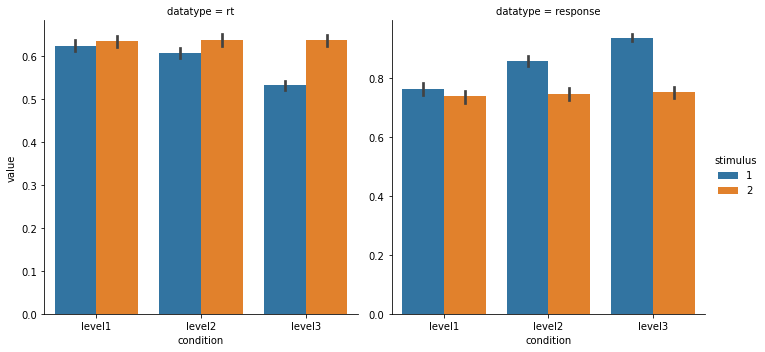

In [5]:
## plot the RT and Accuracy

# wide-to-long format
df_plot = pd.melt(mydata, 
                  id_vars=['subj_idx', 'condition','stimulus'], 
                  value_vars=['rt', 'response'],
                  var_name='datatype')
# df_plot.head()

# way 1: 
# stim_ord = df_plot.stimulus.unique()
# g = sns.FacetGrid(df_plot, col="datatype", 
#                  sharex=False,
#                   sharey=False,
#                  height=4)
# g.map(sns.barplot, "condition", "value",'stimulus', hue_order=np.unique(df_plot["stimulus"]))

# Way 2: 
g = sns.catplot(data=df_plot, x='condition', y='value', hue='stimulus', col='datatype', kind='bar',
               sharex=False, sharey=False)

Below we will use accuracy-coding and stim-coding to model the data. Accordingly, we need to change the way of organizing the data.

In accuracy-coding, response is accuracy, which is the same as the above simulation.

In stimulus-coding, response is the key participants' actual response, an additional stim_col indicate the response participant should response. (**Is this only the case for HDDMStim?**)

Let's assume that stimulus = 1.0 means participants should press the left key, stimulus = 2.0 idicate the right key.

Then, we should re-organize the data as follow:

stimulus = 1.0 & accuracy = 1 => response is left (i.e., the acutal response is 0)

stimulus = 2.0 & accuracy = 1 => resposne is right (i.e., the acutal response is 1)

stimulus = 1.0 & **accuracy = 0** => response is **right (i.e., the acutal response is 1)**

stimulus = 2.0 & **accuracy = 0** => resposne is **left (i.e., the acutal response is 0)**


In [7]:
# data for accuracy-coding modelling, response is accuracy.
# added a column for the stimulus type: 1.0 = left; 2.0 = right.

df_acc = mydata.copy() # cannot use df_acc = mydata, otherwise, mydata will be also changed as df_acc change
df_acc['StimType'] = np.where(df_acc['stimulus'] == 1.0, 'left', 'right')

# data for stimulus coding
df_stim = mydata.copy()
df_stim.rename(columns={'response':'accuracy'}, inplace=True)
df_stim['StimType'] = np.where(df_stim['stimulus'] == 1.0, 'left', 'right')

# left stim, left response
df_stim.loc[(df_stim['StimType'] == 'left') & (df_stim['accuracy'] == 1.0),'response']= 0

# left stim, right response
df_stim.loc[(df_stim['StimType'] == 'left') & (df_stim['accuracy'] != 1.0),'response']= 1

# right stim, right resp
df_stim.loc[(df_stim['StimType'] == 'right') & (df_stim['accuracy'] == 1.0),'response']= 1

# right stim, left resp
df_stim.loc[(df_stim['StimType'] == 'right') & (df_stim['accuracy'] == 0.0),'response']= 0

# df_stim['response'] = np.where(df_stim['StimType'] == 'left' & df_stim['accuracy'] == 1.0, 0, 1)

# change the stimulus column
# df_stim.loc[(df_stim['StimType'] == 'left'),'stim']= 0
# df_stim.loc[(df_stim['StimType'] == 'right'),'stim']= 1

# df_stim.head()

df_acc = pd.merge(df_acc, df_params)
df_stim = pd.merge(df_stim, df_params)

In [8]:
df_stim.head()

,rt,accuracy,subj_idx,condition,stimulus,StimType,response,a_pop,st_pop,sv_pop,sz_pop,t_pop,v_pop,z_pop
0,0.437767,0.0,0,level1,1,left,1.0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332
1,0.383435,0.0,0,level1,1,left,1.0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332
2,0.281557,0.0,0,level1,1,left,1.0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332
3,0.362459,0.0,0,level1,1,left,1.0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332
4,0.576269,1.0,0,level1,1,left,0.0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332


### Step 2: Check the data itself

Here we analyze the data as an experiment and plot it's summary data. More importantly, we will check the correaltion between different condition across subjects.

What we found?

RT and ACC are correlated within each stimulus type (between level 1, 2, and 3) but not across stimulus type. Does it mean that we need to change the way to simulate the data?

Note: here we can use plotly later for checking each individual's RT distribution in different conditions.

In [9]:
def plot_sum_cor(df, var = 'rt'):
    '''
    df: simulated dataframe
    var: the variable of which the summary data will be plotted, i.e., rt or response
    '''
    df_sum = df.groupby(['subj_idx', 'condition', 'StimType'])[var].mean().reset_index()

    # long to wide for pair plots
    df_sum_wide = df_sum.pivot_table(index=['subj_idx'], 
                                     columns=['condition','StimType'],
                                          #aggfunc='size', 
                                     values = var,     
                                     fill_value=0) 

    df_sum_wide.columns = df_sum_wide.columns.map('_'.join)
    df_sum_wide = df_sum_wide.reset_index() 

    # plot pairs with regression lines
    sns.pairplot(df_sum_wide.loc[:, df_sum_wide.columns != 'subj_idx'], kind="reg")
    
    print('Here is the correlation matrix of ', var)
    print(df_sum_wide.loc[:, df_sum_wide.columns != 'subj_idx'].corr())

Here is the correlation matrix of  rt
              level1_left  level1_right  level2_left  level2_right  \
level1_left      1.000000      0.936725     0.892304      0.925483   
level1_right     0.936725      1.000000     0.936693      0.915062   
level2_left      0.892304      0.936693     1.000000      0.858780   
level2_right     0.925483      0.915062     0.858780      1.000000   
level3_left      0.806778      0.853386     0.934531      0.803339   
level3_right     0.937927      0.900586     0.912781      0.880051   

              level3_left  level3_right  
level1_left      0.806778      0.937927  
level1_right     0.853386      0.900586  
level2_left      0.934531      0.912781  
level2_right     0.803339      0.880051  
level3_left      1.000000      0.871170  
level3_right     0.871170      1.000000  


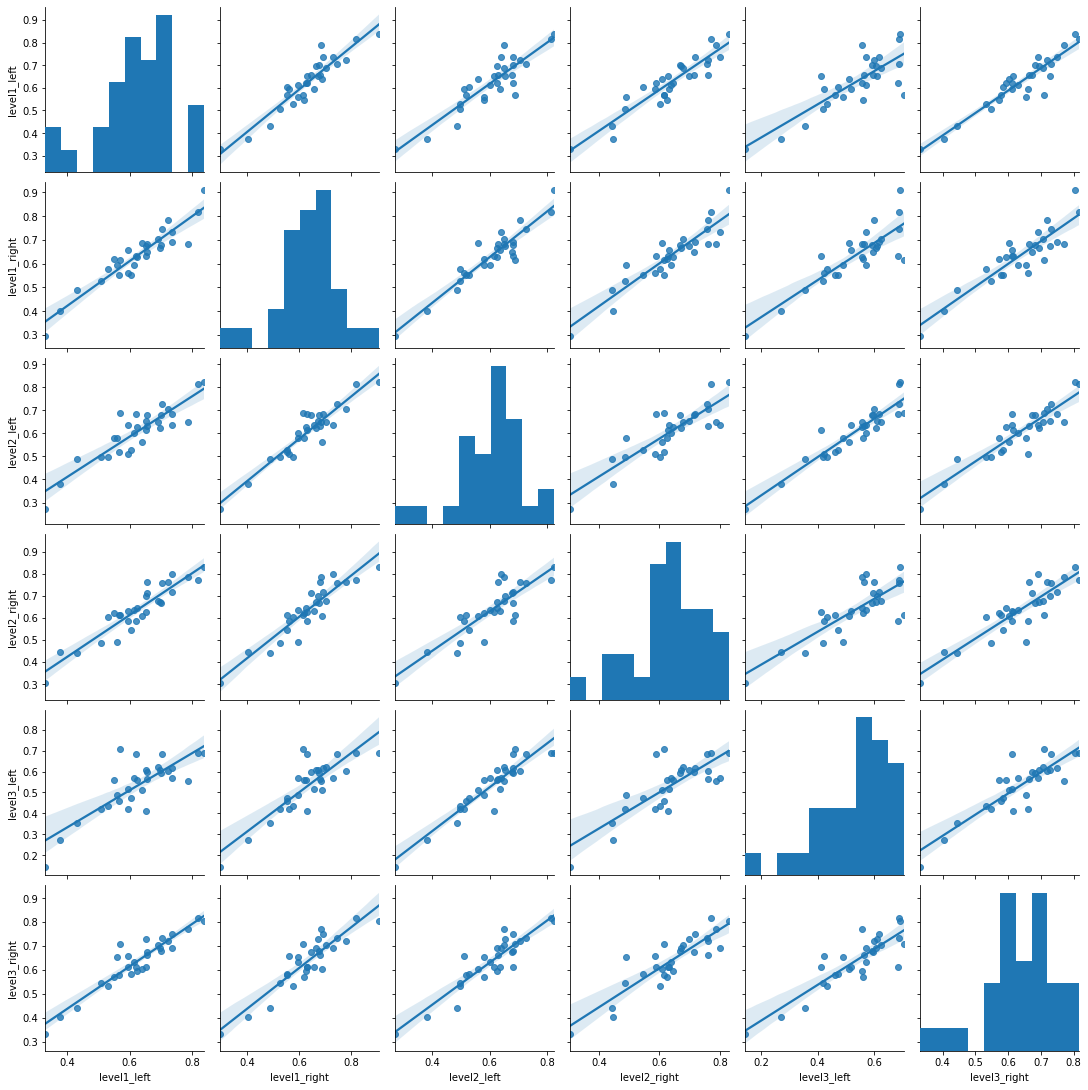

In [10]:
plot_sum_cor(df_acc, 'rt')

Here is the correlation matrix of  response
              level1_left  level1_right  level2_left  level2_right  \
level1_left      1.000000      0.873483     0.751402      0.884106   
level1_right     0.873483      1.000000     0.774076      0.891757   
level2_left      0.751402      0.774076     1.000000      0.698936   
level2_right     0.884106      0.891757     0.698936      1.000000   
level3_left      0.778589      0.762370     0.821937      0.728074   
level3_right     0.890392      0.875885     0.821204      0.875447   

              level3_left  level3_right  
level1_left      0.778589      0.890392  
level1_right     0.762370      0.875885  
level2_left      0.821937      0.821204  
level2_right     0.728074      0.875447  
level3_left      1.000000      0.713577  
level3_right     0.713577      1.000000  


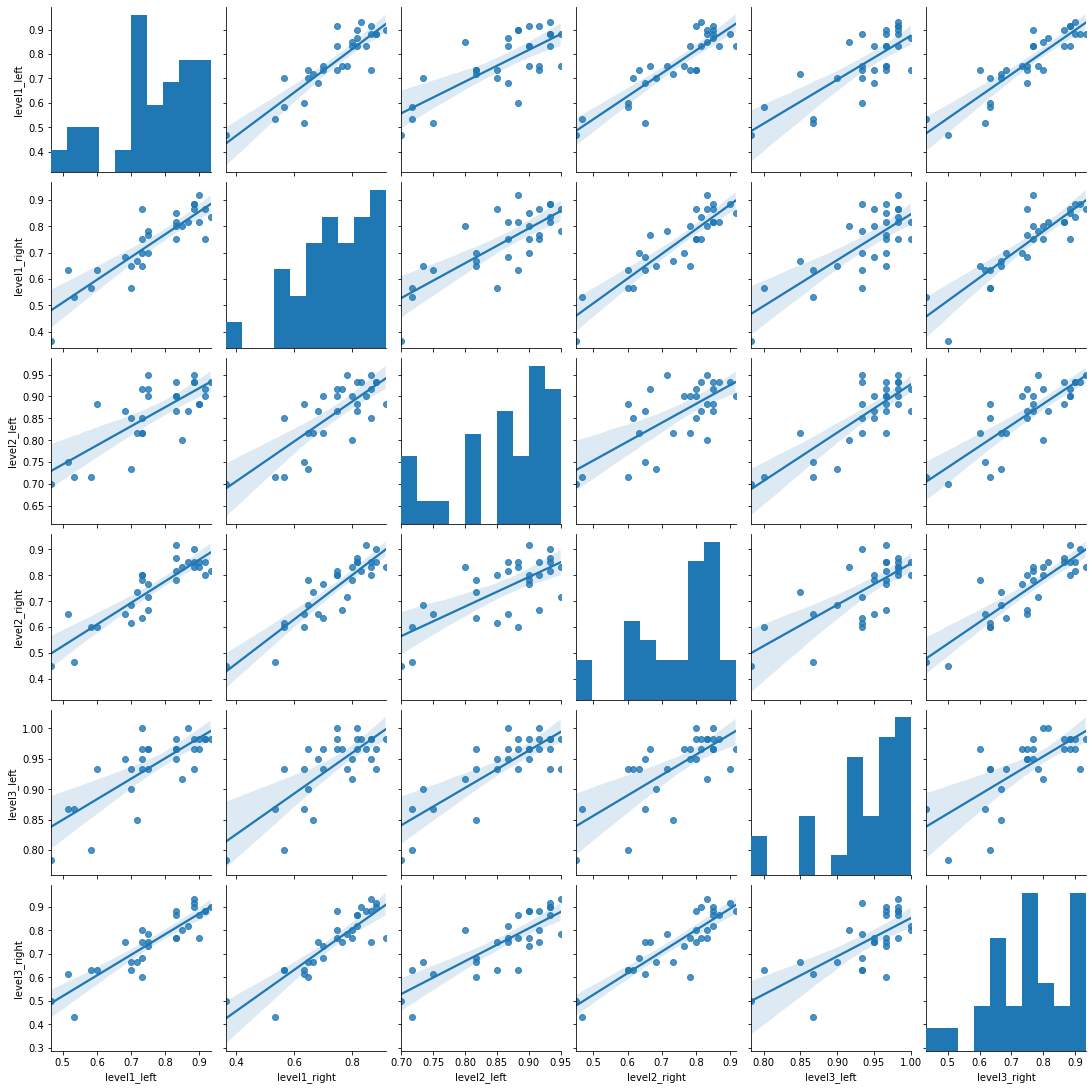

In [11]:
plot_sum_cor(df_acc, 'response')

#### M1: Accuracy coding + HDDM

The first model, use the simple between-subject design model and accuracy-coding. This looks like the most unlikely.

m1 = hddm:HDDM(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]},...)

In [11]:
m1 = hddm.HDDM(df_acc, depends_on={'v': ['condition', 'StimType'], 'z': ['condition', 'StimType']}, 
               include=['v', 'z', 't'],p_outlier=.05)

m1.find_starting_values()
m1.sample(10000,burn=5000, dbname='stim_sim_m1.db', db='pickle')
# 2001 of 2000 complete in 1797.8 sec

# save the model
m1.save('stim_sim_m1')

m1.print_stats()

/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10001 of 10000 complete in 8346.7 sec-----------------53%                  ] 5333 of 10000 complete in 4462.5 sec                              mean         std       2.5q        25q        50q        75q      97.5q       mc err
a                          1.33446   0.0201897    1.29513     1.3212    1.33402    1.34745    1.37459  0.000396606
a_std                      0.10183    0.016495  0.0739689  0.0899317   0.100333   0.111876   0.137777  0.000372697
a_subj.0                   1.48259   0.0366278    1.41057    1.45802    1.48313    1.50715    1.55273  0.000751247
a_subj.1                   1.34089    0.034067    1.27629    1.31764    1.34024    1.36357    1.40989  0.000661492
a_subj.2                   1.29985   0.0312371    1.23845    1.27847    1.29987    1.32102    1.36195  0.000553974
a_subj.3                   1.31066   0.0329554    1.24839    1.28803    1.30992    1.33279    1.37732  0.000655392
a_subj.4                   1.29919   0.0

In [12]:
# load the model data if it was previously saved
m1 = hddm.load('stim_sim_m1')

Check parameter recovery

Check the correlation between recovered parameters and the ground truth.

Also check the correlation between recovered parameters themselves to see if there exist trade-off between parameters.

In [13]:
def gen_params_comp(m, df_params):
    '''
    merge the group-level parameters from model fitting with the ground truth of simulation.
    for later plotting and correlation analysis
    '''
    
    m_stats = m.gen_stats()
    m_stats['params'] = m_stats.index
    m_stats.head()

    m_stats_subj = m_stats[m_stats['params'].str.contains("z_subj|v_subj")]
    m_stats_subj[['param','subj']] = m_stats_subj['params'].str.split("_",expand=True) 
    m_stats_subj[['subj','conds','subj_idx']] = m_stats_subj['subj'].str.split("\(|\)",expand=True) 

    # https://stackoverflow.com/questions/46124469/shape-mismatch-indexing-arrays-could-not-be-broadcast-together-with-shapes
    m_stats_subj[['subj_idx']] = m_stats_subj['subj_idx'].str.split(".",expand=True)[1][:,np.newaxis] 
    m_stats_subj[['StimType', 'condition']] = m_stats_subj['conds'].str.split(".",expand=True).loc[:,0:1]
    m_stats_subj = m_stats_subj.drop(['subj', 'conds'], axis=1).copy()

    m_stats_subj_wide = m_stats_subj.pivot_table(index=['subj_idx', 'condition', 'StimType'], 
                                     columns=['param'],
                                     aggfunc='first', 
                                     values = 'mean',     
                                     fill_value=0) 
    #m1_stats_subj_wide.columns = m1_stats_subj_wide.columns.map('_'.join)
    m_stats_subj_wide.reset_index(inplace=True)  

    # reset the index
    m_stats_subj_wide.index = df_params.index

    # change the data type of 'subj_idx'
    m_stats_subj_wide['subj_idx'] = m_stats_subj_wide['subj_idx'].astype(int)
    
    df_params_ppc = pd.merge(df_params, m_stats_subj_wide)
    return df_params_ppc  

In [14]:
tmp = gen_params_comp(m1, df_params)

In [15]:
# correlation between variables.
tmp.groupby(['StimType', 'condition'])[['v','v_pop','z', 'z_pop']].corr()

v     v_pop         z     z_pop
StimType condition                                              
left     level1    v      1.000000  0.341633  0.408808  0.564009
                   v_pop  0.341633  1.000000  0.155761  0.089086
                   z      0.408808  0.155761  1.000000  0.918378
                   z_pop  0.564009  0.089086  0.918378  1.000000
         level2    v      1.000000  0.393496  0.345469  0.457232
                   v_pop  0.393496  1.000000  0.165602  0.089086
                   z      0.345469  0.165602  1.000000  0.897182
                   z_pop  0.457232  0.089086  0.897182  1.000000
         level3    v      1.000000  0.421645  0.474895  0.516204
                   v_pop  0.421645  1.000000  0.098691  0.089086
                   z      0.474895  0.098691  1.000000  0.905850
                   z_pop  0.516204  0.089086  0.905850  1.000000
right    level1    v      1.000000  0.549699  0.644000  0.706077
                   v_pop  0.549699  1.000000  0.164270  0.089086
                   z      0.644000  0.164270  1.000000  0.922937
                   z_pop  0.706077  0.089086  0.922937  1.000000
         level2    v      1.000000  0.437094  0.250512  0.496052
                   v_pop  0.437094  1.000000  0.040276  0.089086
                   z      0.250512  0.040276  1.000000  0.924058
                   z_pop  0.496052  0.089086  0.924058  1.000000
         level3    v      1.000000  0.490832  0.622202  0.723971
                   v_pop  0.490832  1.000000  0.052742  0.089086
                   z      0.622202  0.052742  1.000000  0.940414
                   z_pop  0.723971  0.089086  0.940414  1.000000

[None, None]

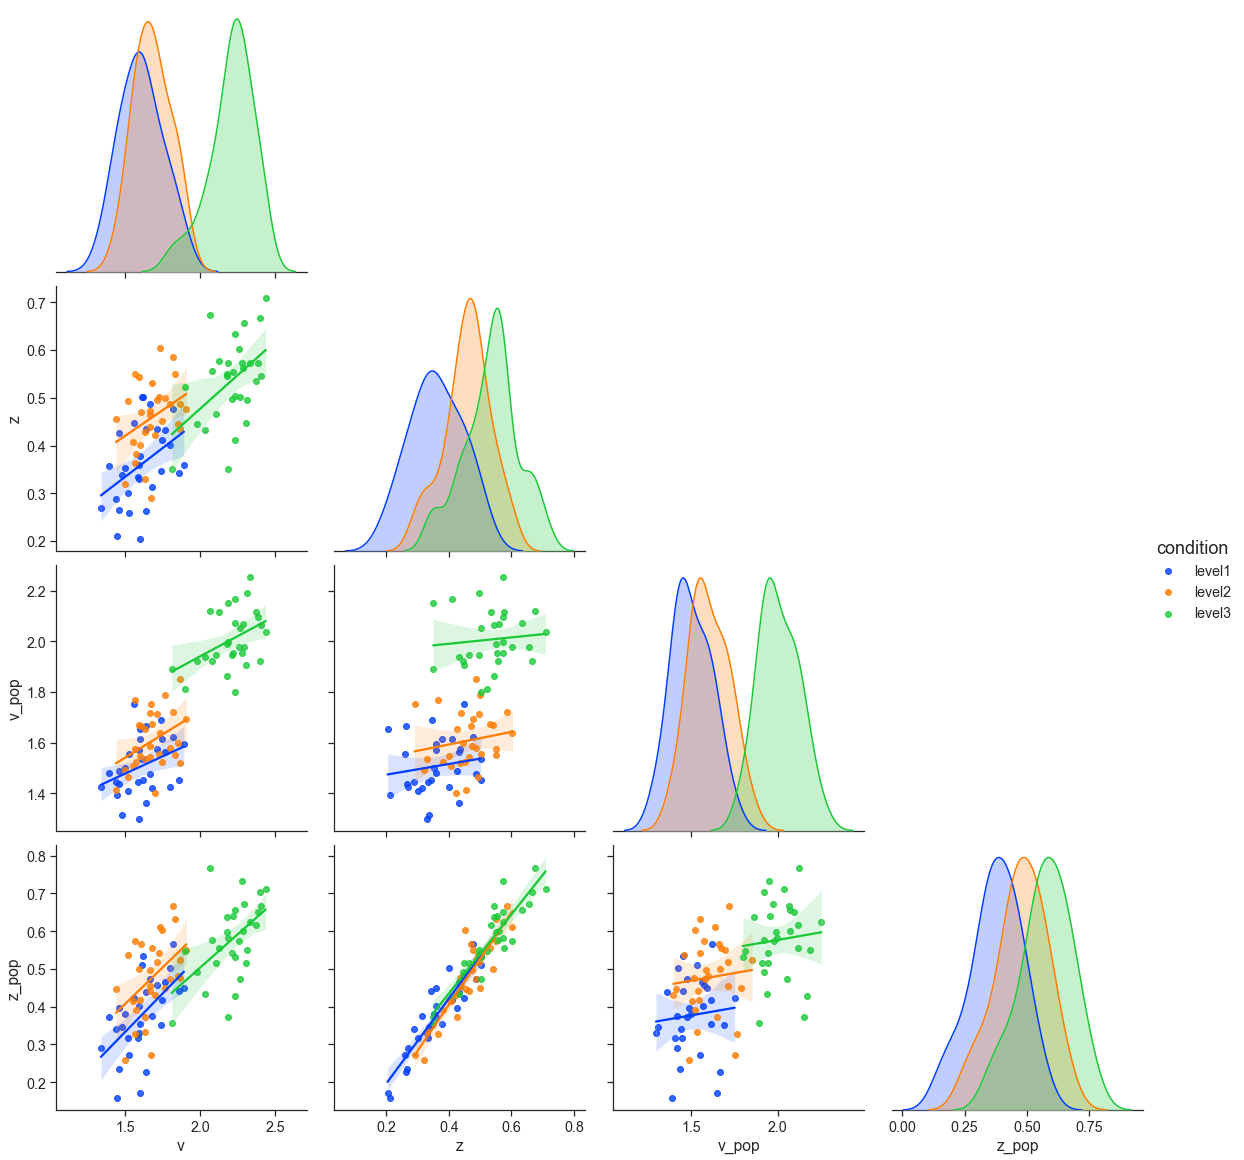

In [16]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

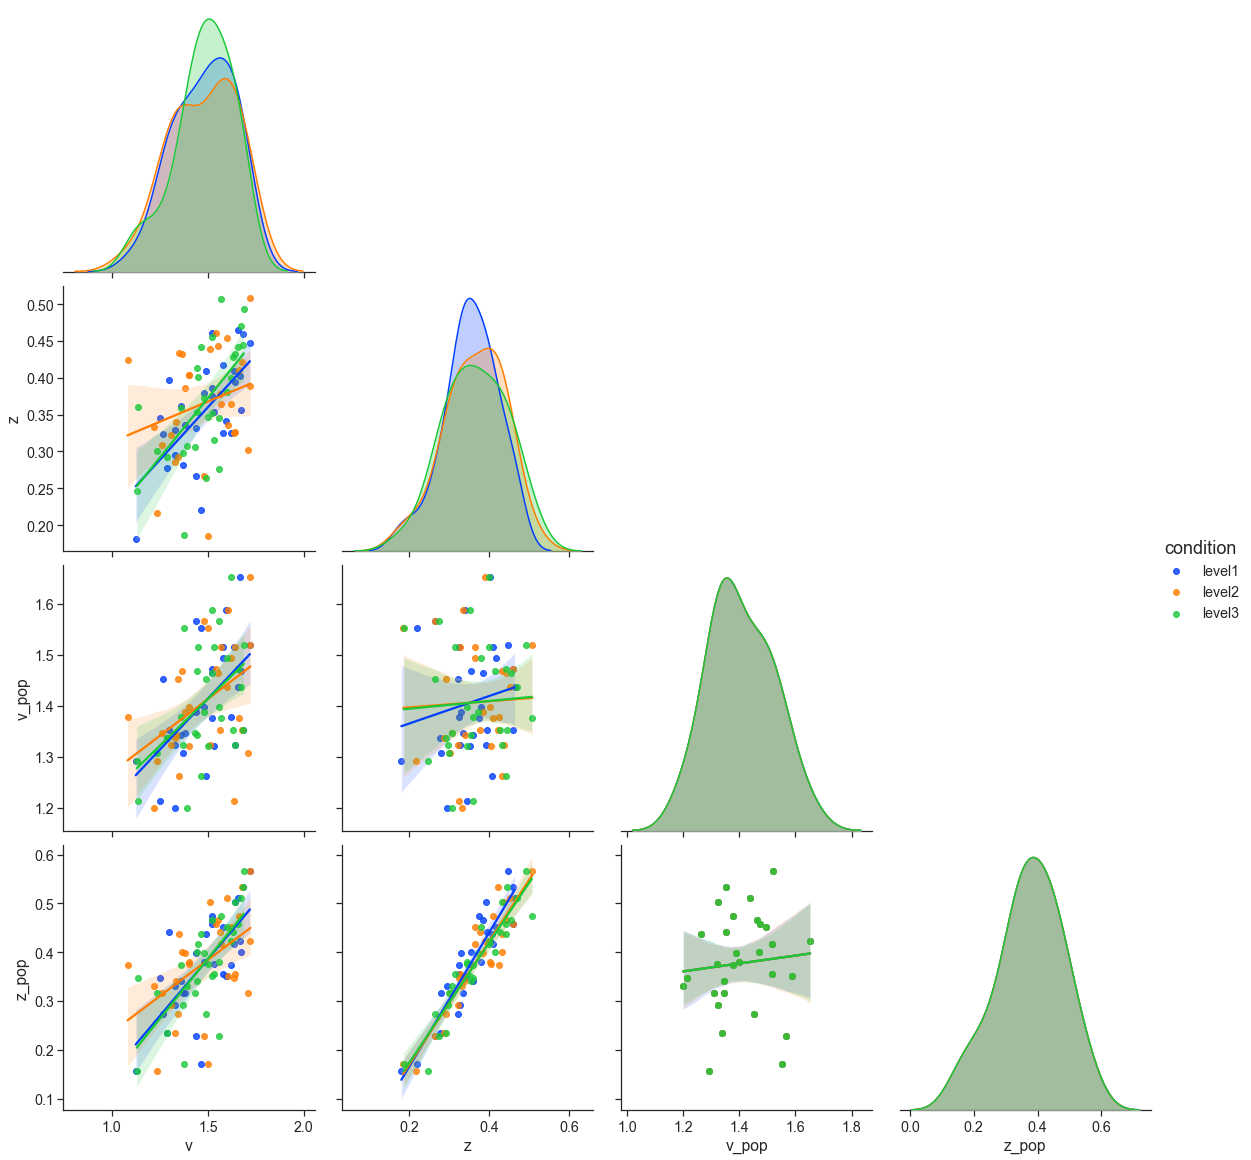

In [17]:
# pair plot for right stimuli
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

Another step could be used for mode recovery: PPC.

In [17]:
m1_ppc_data = hddm.utils.post_pred_gen(m1)
#m1_ppc_data.head()

ppc_compare = hddm.utils.post_pred_stats(df_acc, m1_ppc_data)
print(ppc_compare)

 [-----------------101%-----------------] 183 of 180 complete in 977.8 sec

/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


          observed      mean       std           SEM       MSE credible  \
stat                                                                      
accuracy  0.800463  0.812847  0.122139  1.533574e-04  0.015071     True   
mean_ub   0.633092  0.644234  0.139156  1.241582e-04  0.019489     True   
std_ub    0.273806  0.244591  0.065846  8.535403e-04  0.005189     True   
10q_ub    0.343248  0.411981  0.115978  4.724283e-03  0.018175     True   
30q_ub    0.485625  0.490998  0.124155  2.886894e-05  0.015443     True   
50q_ub    0.588249  0.578829  0.135255  8.874339e-05  0.018383     True   
70q_ub    0.719139  0.702790  0.153321  2.672976e-04  0.023775     True   
90q_ub    0.980014  0.954091  0.200425  6.720098e-04  0.040842     True   
mean_lb  -0.528065 -0.543976  0.148179  2.531643e-04  0.022210     True   
std_lb    0.246310  0.188854  0.104047  3.301230e-03  0.014127     True   
10q_lb    0.293192  0.381185  0.137423  7.742776e-03  0.026628     True   
30q_lb    0.392466  0.427

In [18]:
ppc_stats = hddm.utils.post_pred_stats(df_acc, m1_ppc_data, call_compare=False)
print(ppc_stats.head())

/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                            accuracy   mean_ub    std_ub    10q_ub    30q_ub  \
node                sample                                                     
wfpt(left.level1).0 0       0.583333  0.708289  0.161099  0.525398  0.603998   
                    1       0.500000  0.675748  0.180410  0.500321  0.568001   
                    2       0.533333  0.935170  0.437163  0.493846  0.672106   
                    3       0.583333  0.762755  0.285749  0.501190  0.572670   
                    4       0.550000  0.897758  0.411867  0.542042  0.649622   

                              50q_ub    70q_ub    90q_ub   mean_lb    std_lb  \
node                sample                                                     
wfpt(left.level1).0 0       0.659578  0.762898  0.947498 -0.477864  0.279738   
                    1       0.611081  0.763711  0.899461 -0.442025  0.249439   
                    2       0.818686  1.034996  1.736886 -0.493286  0.262977   
                    3       0.675270  0

/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/kabuki/analyze.py:568: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn('Too many nodes. Consider increasing number of columns.')
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/kabuki/analyze.py:568: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn('Too many nodes. Consider increasing number of columns.')
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/kabuki/analyze.py:568: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn('Too many nodes. Consider increasing number of columns.')
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/kabuki/analyze.py:568: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn('Too many nodes. Consider increasing number of columns.')
/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/kabuki/analyze.py:568: Us

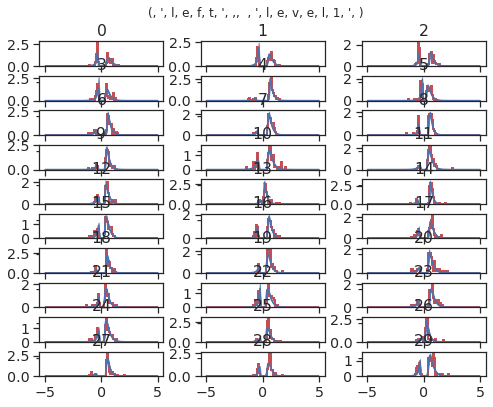

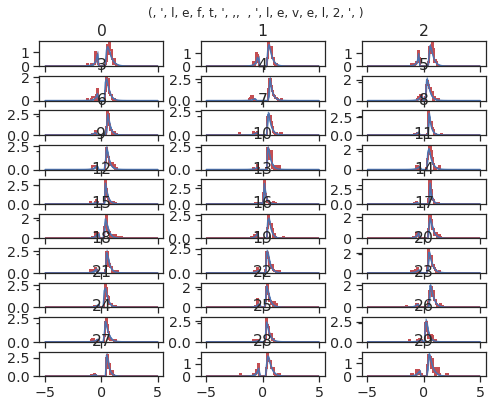

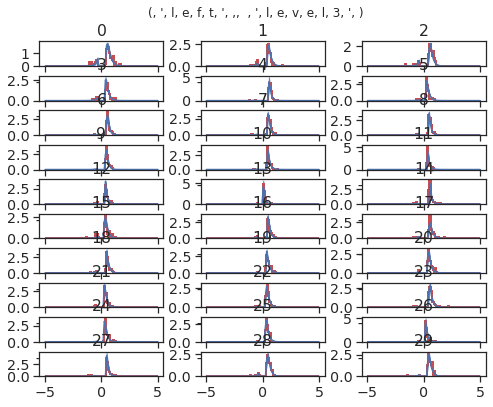

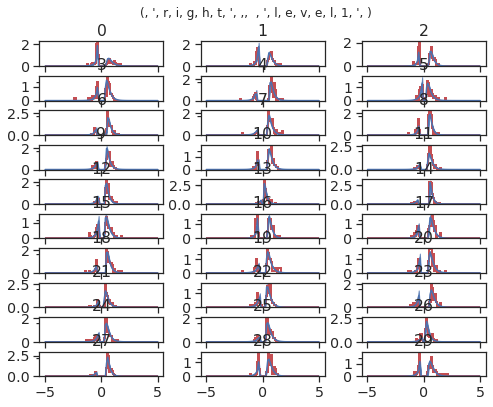

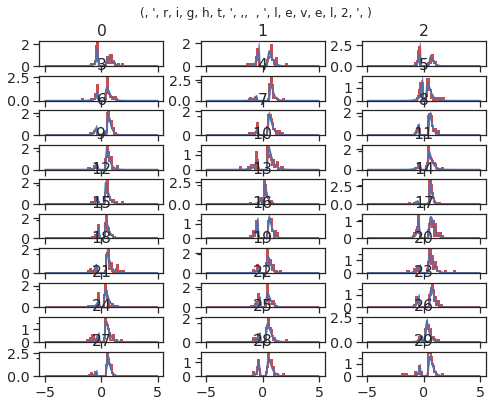

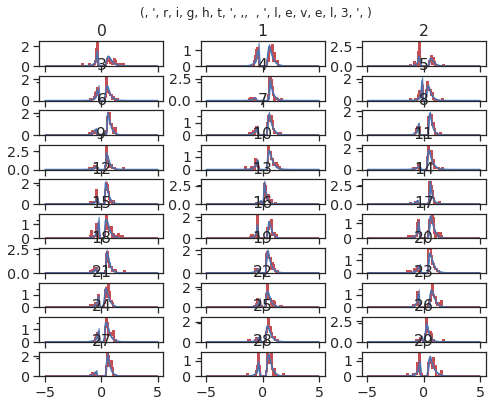

In [19]:
m1.plot_posterior_predictive()

#### M2: Stimcoding with HDDMStimcoding: Way 1

This model still use between-subj design, but use the stimcoding as assumed in the tutorial, i.e., assuming that the response doesn't matter.

m2 = hddm:HDDMStimcoding(depends_on = {'v': [levels], 'z':[levels]}, ...)

Even the number of parameters are different from recovered here and the ground truth data, we nevertheless tried to compare them.


In [25]:
# Should not use 'data = df_stim'
m2 = hddm.HDDMStimCoding(df_stim, include=['z'],
                         stim_col='stimulus',
                         depends_on={'v': ['condition'], 'z':['condition']}, 
                         p_outlier=.05,
                         split_param='v',
                         drift_criterion=False)                                    

m2.find_starting_values()
m2.sample(10000,burn = 5000, dbname='stim_sim_m2.db', db='pickle')
# 2001 of 2000 complete in 1699.4 sec 

# save the model
m2.save('stim_sim_m2')
#C_val_vtz = hddm.load('C_val_vtz')

m2.print_stats()

 [-----------------100%-----------------] 10001 of 10000 complete in 7848.1 sec                        mean         std       2.5q        25q        50q        75q      97.5q       mc err
a                    1.30248   0.0190284    1.26585    1.28976    1.30205    1.31464    1.34189  0.000285101
a_std               0.093741   0.0157096  0.0675006  0.0824558  0.0921415   0.103542   0.128177  0.000380172
a_subj.0             1.31213   0.0327119    1.24845    1.28982    1.31153    1.33393     1.3782  0.000641894
a_subj.1             1.26753   0.0318375     1.2052    1.24622     1.2675    1.28921    1.32913  0.000518488
a_subj.2             1.15841   0.0302652    1.10045    1.13825    1.15775    1.17856    1.21956  0.000705114
a_subj.3             1.24912   0.0301325    1.19237    1.22861    1.24876    1.26913     1.3085  0.000561099
a_subj.4             1.29194    0.036819     1.2203    1.26753    1.29129    1.31615    1.36533  0.000860769
a_subj.5             1.27947   0.0326694    1.217

#### M3: Stimcoding with HDDMStimcoding: Way 2

The second way is treating the stimulus matters and add stimu as an addition factor, the pseudo code is like:

m3 = hddm:HDDMStimcoding(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]}, ...)


In [26]:
# Should not use 'data = df_stim'
m3 = hddm.HDDMStimCoding(df_stim, include=['z'],
                         stim_col='stimulus',
                         depends_on={'v': ['condition', 'StimType'], 'z': ['condition', 'StimType']}, 
                         p_outlier=.05,
                         split_param='v',
                         drift_criterion=False)                                    

m3.find_starting_values()
m3.sample(10000,burn = 5000, dbname='stim_sim_m3.db', db='pickle')
# 2001 of 2000 complete in 1793.5 sec

# save the model
m3.save('stim_sim_m3')
# m3 = hddm.load('stim_sim_m3')

m3.print_stats()

 [-----------------100%-----------------] 10001 of 10000 complete in 8525.0 sec                              mean         std       2.5q        25q        50q        75q      97.5q       mc err
a                          1.33447    0.020548    1.29401    1.32101    1.33428    1.34767    1.37585  0.000397375
a_std                     0.101539   0.0163665  0.0743902  0.0897456   0.100304   0.111239   0.138929  0.000354171
a_subj.0                   1.48362   0.0379162    1.40818    1.45744     1.4826     1.5088    1.55861  0.000765473
a_subj.1                   1.34084   0.0332402     1.2772    1.31868    1.33981    1.36297    1.40829  0.000705174
a_subj.2                   1.30013   0.0323717    1.23771    1.27848    1.30024    1.32187    1.36469  0.000613663
a_subj.3                   1.31214    0.033574    1.24624    1.28939     1.3117    1.33469    1.37856  0.000728146
a_subj.4                   1.29813   0.0373892    1.22767    1.27313    1.29724    1.32209    1.37544  0.000862327
a

In [18]:
# load the model data if it was previously saved
m3 = hddm.load('stim_sim_m3')

In [27]:
tmp = gen_params_comp(m3, df_params)

In [28]:
# correlation between variables.
tmp.groupby(['StimType', 'condition'])[['v','v_pop','z', 'z_pop']].corr()

v     v_pop         z     z_pop
StimType condition                                              
left     level1    v      1.000000  0.344187 -0.413211  0.570068
                   v_pop  0.344187  1.000000 -0.156825  0.089086
                   z     -0.413211 -0.156825  1.000000 -0.918176
                   z_pop  0.570068  0.089086 -0.918176  1.000000
         level2    v      1.000000  0.394854 -0.331674  0.447497
                   v_pop  0.394854  1.000000 -0.168501  0.089086
                   z     -0.331674 -0.168501  1.000000 -0.895594
                   z_pop  0.447497  0.089086 -0.895594  1.000000
         level3    v      1.000000  0.422634 -0.482549  0.520901
                   v_pop  0.422634  1.000000 -0.099045  0.089086
                   z     -0.482549 -0.099045  1.000000 -0.906807
                   z_pop  0.520901  0.089086 -0.906807  1.000000
right    level1    v      1.000000  0.552069  0.646526  0.706227
                   v_pop  0.552069  1.000000  0.164391  0.089086
                   z      0.646526  0.164391  1.000000  0.922356
                   z_pop  0.706227  0.089086  0.922356  1.000000
         level2    v      1.000000  0.430571  0.249407  0.494398
                   v_pop  0.430571  1.000000  0.041767  0.089086
                   z      0.249407  0.041767  1.000000  0.924398
                   z_pop  0.494398  0.089086  0.924398  1.000000
         level3    v      1.000000  0.491406  0.625623  0.724804
                   v_pop  0.491406  1.000000  0.050572  0.089086
                   z      0.625623  0.050572  1.000000  0.941307
                   z_pop  0.724804  0.089086  0.941307  1.000000

[None, None]

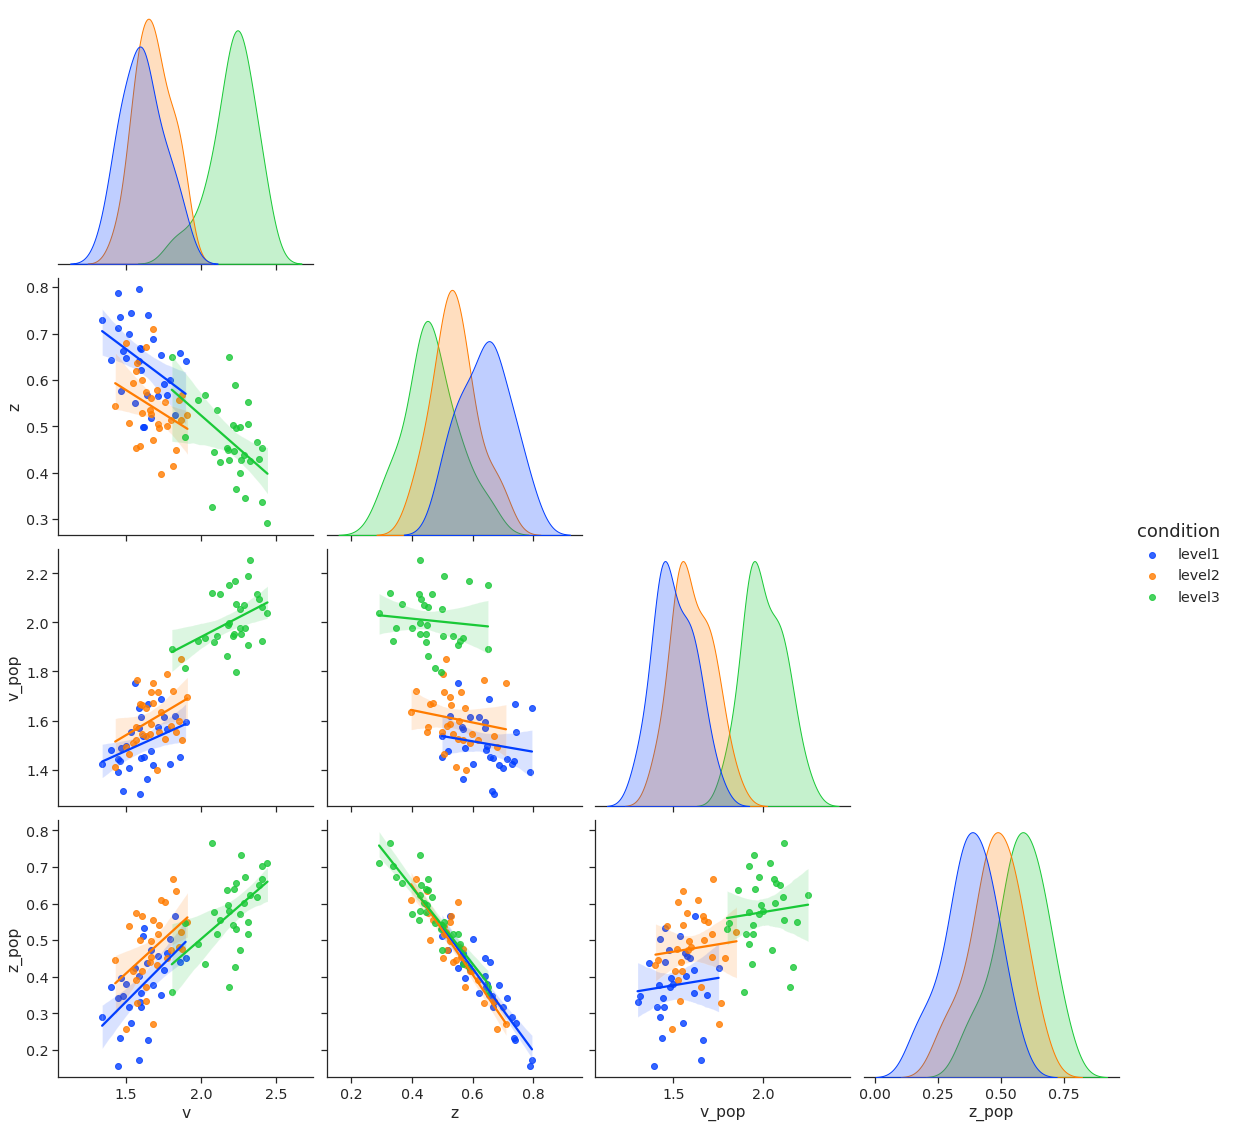

In [29]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

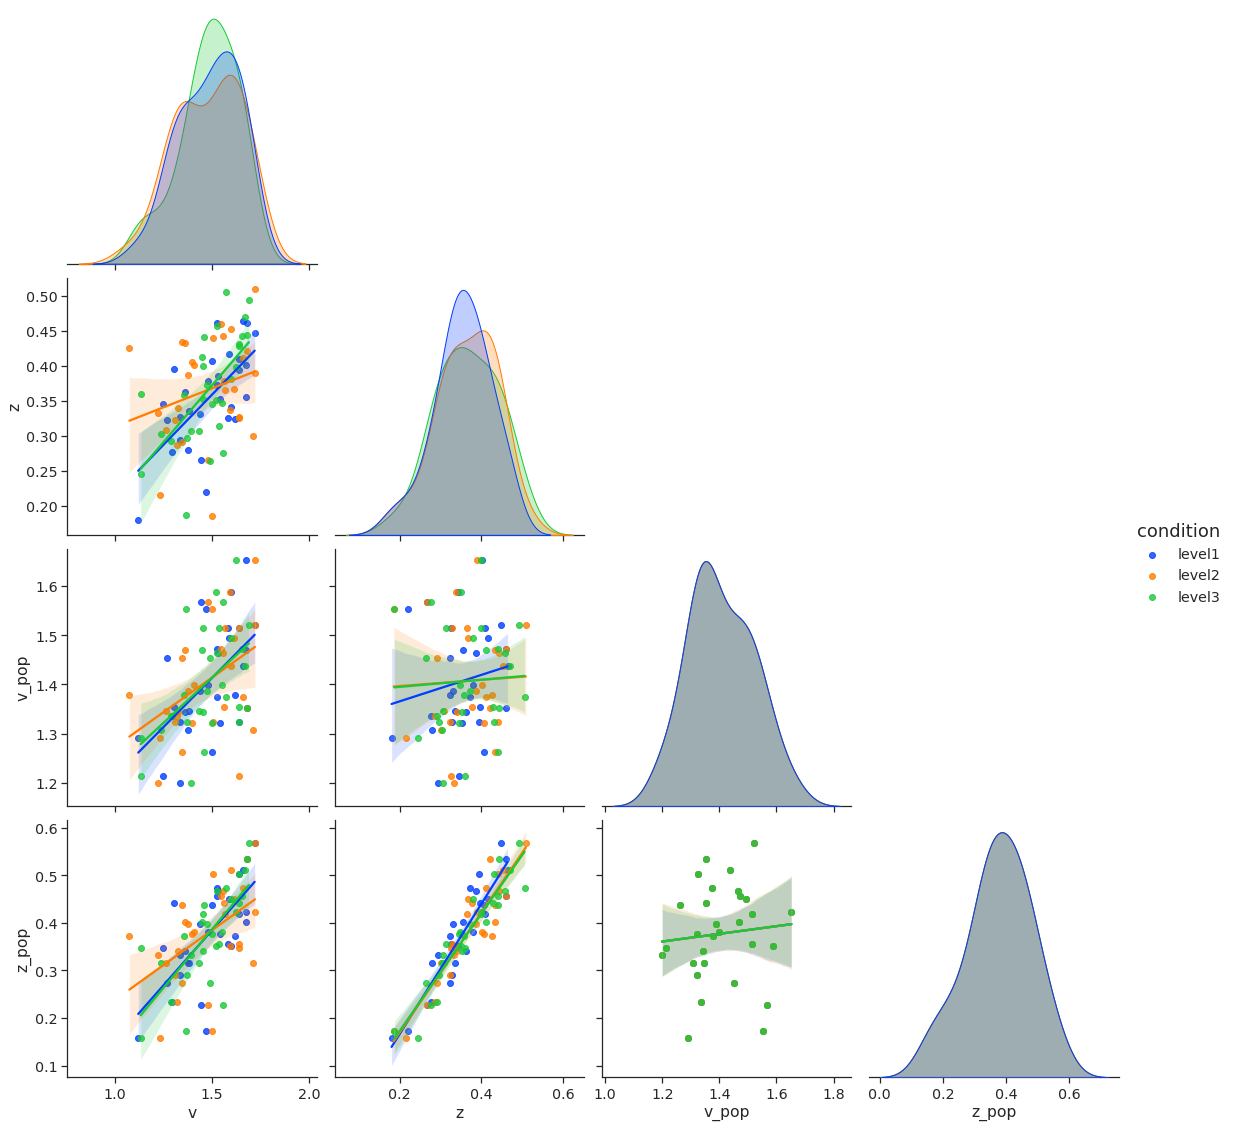

In [30]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

#### M4: Accuracy-coding + regressor
That is, we treat the data as accuracy-coding with within-subject design. The pseudo code is like:

m4 = hddm:HDDMRegressor{ 'v' ~ Stim * levels, 'z' ~ stim * levels, 'link_func':lambda x:1/(1+np.exp(-x))}

For reduced-rank coding, one level is chosen as the “reference”, and its mean behaviour is represented by the intercept. Each column of the resulting matrix represents the difference between the mean of one level and this reference level.

For full-rank coding, classic “dummy” coding is used, and each column of the resulting matrix represents the mean of the corresponding level.

https://patsy.readthedocs.io/en/latest/API-reference.html#handling-categorical-data

$v_{ij} = v_{int} + v_{intsubj} + \beta_{i} * cond_{}i$

$i$ is the condition;

$j$ is the subject index

We first check the full rank coding and reduced rank coding, and then build the model.

In [18]:
## check the regressor in the design

# full rank coding
dmatrix("0 + C(condition, Treatment) * C(StimType, Treatment)", data=df_acc)

DesignMatrix with shape (10800, 6)
  Columns:
    ['C(condition, Treatment)[level1]',
     'C(condition, Treatment)[level2]',
     'C(condition, Treatment)[level3]',
     'C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level2]:C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level3]:C(StimType, Treatment)[T.right]']
  Terms:
    'C(condition, Treatment)' (columns 0:3)
    'C(StimType, Treatment)' (column 3)
    'C(condition, Treatment):C(StimType, Treatment)' (columns 4:6)
  (to view full data, use np.asarray(this_obj))

In [19]:
# reduced rank coding
dmatrix("C(condition, Treatment) * C(StimType, Treatment)", data=df_acc)

DesignMatrix with shape (10800, 6)
  Columns:
    ['Intercept',
     'C(condition, Treatment)[T.level2]',
     'C(condition, Treatment)[T.level3]',
     'C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level2]:C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level3]:C(StimType, Treatment)[T.right]']
  Terms:
    'Intercept' (column 0)
    'C(condition, Treatment)' (columns 1:3)
    'C(StimType, Treatment)' (column 3)
    'C(condition, Treatment):C(StimType, Treatment)' (columns 4:6)
  (to view full data, use np.asarray(this_obj))

In [25]:
z_reg4 = {'model': "z ~ 0 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': lambda x:1/(1+np.exp(-x))}

v_reg4 = {'model': "v ~ 0 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': lambda x:x}

reg_descr4 = [z_reg4, v_reg4]

# Note here the 'group_only_regresors' is set to 'false'
m4 = hddm.HDDMRegressor(df_acc, reg_descr4, group_only_regressors=False, keep_regressor_trace=True, include='z')

m4.find_starting_values()

m4.sample(15000, burn=5000, dbname='stim_sim_m4.db', db='pickle') # 54392.1 sec

# save the model
m4.save('stim_sim_m4')
# m4 = hddm.load('stim_sim_m4')

m4.print_stats()

Adding these covariates:
["z_C(condition, Treatment('level1'))[level1]", "z_C(condition, Treatment('level1'))[level2]", "z_C(condition, Treatment('level1'))[level3]", "z_C(StimType, Treatment('left'))[T.right]", "z_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]", "z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]"]
Adding these covariates:
["v_C(condition, Treatment('level1'))[level1]", "v_C(condition, Treatment('level1'))[level2]", "v_C(condition, Treatment('level1'))[level3]", "v_C(StimType, Treatment('left'))[T.right]", "v_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]", "v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]"]
 [-----------------100%-----------------] 15001 of 15000 complete in 53285.6 secWARNING: Will not save custom link functions.
                                                                                              

In [20]:
m4 = hddm.load('stim_sim_m4')

In [26]:
m_traces = m4.get_traces()
slct_col_names = m_traces.columns[m_traces.columns.str.contains("z_")]
m_traces = m_traces[slct_col_names].copy()

slct_col_names
trace_name = m_traces.columns[m_traces.columns.str.contains("subj.0|subj_trans.0")]

trace_name

Index(['z_C(condition, Treatment('level1'))[level1]_subj_trans.0',
       'z_C(condition, Treatment('level1'))[level2]_subj_trans.0',
       'z_C(condition, Treatment('level1'))[level3]_subj_trans.0',
       'z_C(StimType, Treatment('left'))[T.right]_subj_trans.0',
       'z_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_subj.0',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.0'],
      dtype='object')

In [27]:
slct_col_names

Index(['z_C(condition, Treatment('level1'))[level1]_trans',
       'z_C(condition, Treatment('level1'))[level1]_std',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.0',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.1',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.2',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.3',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.4',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.5',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.6',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.7',
       ...
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.20',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.21',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.22',
       'z_C(condition, 

In [33]:
subj_id = 0
subj_name = 'subj_trans.' + str(subj_id)

l_l1_eff_name = 'z' + "_C(condition, Treatment('level1'))[level2]_" + subj_name
#z_C(condition, Treatment('level1'))[level2]_subj_trans.0'

l_l2_eff_name = 'z' + "_C(condition, Treatment('level1'))[level2]_" + subj_name
l_l3_eff_name = 'z' + "_C(condition, Treatment('level1'))[level3]_" + subj_name
r_l1_eff_name = 'z' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
r_l2_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_subj." + str(subj_id)
r_l3_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj." + str(subj_id)

tmp_l_l1 = m_traces[l_l1_eff_name].copy()
#1/(1+np.exp(-x))
# exp(z_trans)/(1+exp(z_trans)) 
#tmp_l_l1 = 1/(1+np.exp(-tmp_l_l1))
tmp_l_l1 = np.exp(tmp_l_l1)/(1+np.exp(tmp_l_l1))

tmp_l_l2 = m_traces[l_l2_eff_name].copy()
tmp_l_l2 = np.exp(tmp_l_l2)/(1+np.exp(tmp_l_l2))

tmp_l_l3 = m_traces[l_l3_eff_name].copy()
tmp_l_l3 = np.exp(tmp_l_l3)/(1+np.exp(tmp_l_l3))

tmp_r_l1 = m_traces[r_l1_eff_name].copy()
tmp_r_l1 = np.exp(tmp_r_l1)/(1+np.exp(tmp_r_l1))

tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
tmp_r_l2 = np.exp(tmp_r_l2)/(1+np.exp(tmp_r_l2))

tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
tmp_r_l3 = np.exp(tmp_r_l3)/(1+np.exp(tmp_r_l3))

dd = pd.concat([tmp_l_l1, tmp_l_l2, tmp_l_l3, tmp_r_l1, tmp_r_l2, tmp_r_l3], axis=1)
dd.columns = ['left_level1_value', 'left_level2_value', 'left_level3_value', 
              'right_level1_value', 'right_level2_value', 'right_level3_value']
dd

,left_level1_value,left_level2_value,left_level3_value,right_level1_value,right_level2_value,right_level3_value
0,0.070309,0.070309,0.154237,0.029339,0.338040,0.290497
1,0.072966,0.072966,0.156527,0.031692,0.303345,0.352392
2,0.072392,0.072392,0.157353,0.031029,0.301797,0.355828
3,0.071653,0.071653,0.158498,0.031163,0.365833,0.336711
4,0.072048,0.072048,0.155623,0.031167,0.366907,0.273975
...,...,...,...,...,...,...
9995,0.051141,0.051141,0.203514,0.026996,0.309591,0.358451
9996,0.051088,0.051088,0.195087,0.027033,0.323977,0.258293
9997,0.050554,0.050554,0.194454,0.026973,0.319395,0.285360
9998,0.050642,0.050642,0.207501,0.027039,0.323299,0.330730


In [28]:
subj_id = 0
subj_name = 'subj.' + str(subj_id)

l_l1_name = 'z' + "_Intercept_subj_trans." + str(subj_id)
l_l2_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name
l_l3_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name
r_l1_eff_name = 'z' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
r_l2_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
r_l3_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name

tmp_l_l1 = m_traces[l_l1_name].copy()
#1/(1+np.exp(-x))
# exp(z_trans)/(1+exp(z_trans)) 
#tmp_l_l1 = 1/(1+np.exp(-tmp_l_l1))
tmp_l_l1 = np.exp(tmp_l_l1)/(1+np.exp(tmp_l_l1))

tmp_l_l2 = m_traces[l_l2_eff_name].copy()
tmp_l_l2 = np.exp(tmp_l_l2)/(1+np.exp(tmp_l_l2))

tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
tmp_l_l3 = np.exp(tmp_l_l3)/(1+np.exp(tmp_l_l3))

tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
tmp_r_l1 = np.exp(tmp_r_l1)/(1+np.exp(tmp_r_l1))

tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
tmp_r_l2 = np.exp(tmp_r_l2)/(1+np.exp(tmp_r_l2))

tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
tmp_r_l3 = np.exp(tmp_r_l3)/(1+np.exp(tmp_r_l3))

dd = pd.concat([tmp_l_l1, tmp_l_l2, tmp_l_l3, tmp_r_l1, tmp_r_l2, tmp_r_l3], axis=1)
dd.columns = ['left_level1_value', 'left_level2_value', 'left_level3_value', 
              'right_level1_value', 'right_level2_value', 'right_level3_value']
dd
# df_subj_traces = pd.DataFrame(columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value',
#                                          'left_level3_value', 'right_level1_value', 'right_level2_value', 
#                                          'right_level3_value'])

KeyError: 'z_Intercept_subj_trans.0'

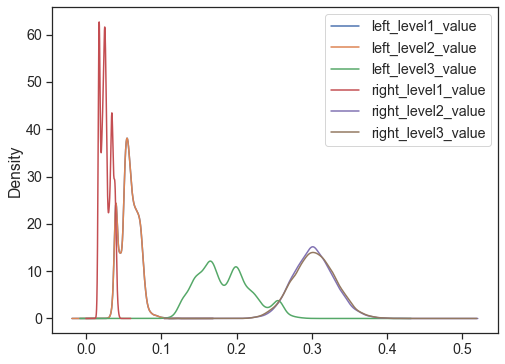

In [34]:
dd.plot.density(figsize=(8,6))

In [35]:
n_subjects = 30
def gen_params_comp_reg(m, df_params):
    '''
    merge the group-level parameters from model fitting with the ground truth of simulation.
    for later plotting and correlation analysis
    This function is for reduced rank model.
    
    Note, need to converte z_trans back to z
    Link: https://groups.google.com/g/hddm-users/c/k0SfUbQ-Tnw
    z = exp(z_trans)/(1+exp(z_trans)) 
    
    '''
    m_traces = m.get_traces()
    
    # create an empty dataframe to store the parameters.
    df_subj_traces = pd.DataFrame(columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value',
                                             'left_level3_value', 'right_level1_value', 'right_level2_value', 
                                             'right_level3_value'])
    for subj_id in range(n_subjects):
        for param in ['v', 'z']:
            if param == 'v':
                # create strings for extracting the traces of 'v' for each condition
                subj_name = 'subj.' + str(subj_id)
                
                # Name for intercept, which is left_level1's parameter
                l_l1_name = 'v' + "_Intercept_" + subj_name 
                # Name for the difference between left_level2 and intercept
                l_l2_eff_name = 'v' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name 
                # Name for the diff between left_level3 and intercept
                l_l3_eff_name = 'v' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name 
                # name for the diff between right_level1 and intercept
                r_l1_eff_name = 'v' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
                # Name for the diff between right_level2 and right_level1 (interaction of right_level2)
                r_l2_int_name = 'v' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                # Name for the diff between right_level3 and right_level1 (interaction of right_level3)
                r_l3_int_name = 'v' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                
                # get the data (MCMC traces of all these conditions)
                tmp_l_l1 = m_traces[l_l1_name].copy()
                tmp_l_l2 = tmp_l_l1 + m_traces[l_l2_eff_name].copy()
                tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
                tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
                tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
                tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
            else:
                # create strings for extracting the traces of 'z' for each condition
                subj_name = 'subj.' + str(subj_id)
                l_l1_name = 'z' + "_Intercept_subj_trans." + str(subj_id)
                l_l2_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name
                l_l3_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name
                r_l1_eff_name = 'z' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
                r_l2_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                r_l3_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name

                tmp_l_l1 = m_traces[l_l1_name].copy()
                
                # transfer z_trans to z, using exp(z_trans)/(1+exp(z_trans)), which is equal to 1/(1+np.exp(-x))
                tmp_l_l1 = np.exp(tmp_l_l1)/(1+np.exp(tmp_l_l1))

                tmp_l_l2 = m_traces[l_l2_eff_name].copy()
                tmp_l_l2 = np.exp(tmp_l_l2)/(1+np.exp(tmp_l_l2))

                tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
                tmp_l_l3 = np.exp(tmp_l_l3)/(1+np.exp(tmp_l_l3))

                tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
                tmp_r_l1 = np.exp(tmp_r_l1)/(1+np.exp(tmp_r_l1))

                tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
                tmp_r_l2 = np.exp(tmp_r_l2)/(1+np.exp(tmp_r_l2))

                tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
                tmp_r_l3 = np.exp(tmp_r_l3)/(1+np.exp(tmp_r_l3))

            # put all these six conditions' mean data together   
            dat= [[param, subj_id, np.mean(tmp_l_l1), np.mean(tmp_l_l2), np.mean(tmp_l_l3), 
                   np.mean(tmp_r_l1), np.mean(tmp_r_l2), np.mean(tmp_r_l3)]]
            
            # create a dataframe from those data
            dd = pd.DataFrame(dat, columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value', 'left_level3_value', 'right_level1_value', 'right_level2_value', 'right_level3_value'])
            
            # append the above as a row for the final dataframe
            df_subj_traces = df_subj_traces.append(dd, ignore_index=True)
                                             

    # melt the dataframe, i.e., wide to long format
    df_subj_traces = pd.melt(df_subj_traces, id_vars=['subj_idx', 'params'], 
                             value_vars=['left_level1_value', 'left_level2_value', 'left_level3_value',
                                         'right_level1_value', 'right_level2_value', 'right_level3_value'])

    df_subj_traces[['StimType','condition','v_name']] = df_subj_traces['variable'].str.split("_",expand=True)
    
    # Long to wide so the v and z are from different columns 
    df_subj_traces = df_subj_traces.pivot_table(index=['subj_idx', 'condition','StimType'], columns='params', values='value')
    df_subj_traces.reset_index(inplace=True) 
    
    # change the data type of 'subj_idx'
    df_subj_traces['subj_idx'] = df_subj_traces['subj_idx'].astype(int)
    df_params_ppc = pd.merge(df_params, df_subj_traces)
    
    return df_params_ppc  

In [36]:
df_params_ppc = gen_params_comp_reg(m4, df_params)
df_params_ppc.head(10)

,condition,subj_idx,a_pop,st_pop,sv_pop,sz_pop,t_pop,v_pop,z_pop,stimulus,StimType,v,z
0,level1,0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332,1,left,0.103727,0.026853
1,level1,1,1.220791,0.133319,0.015975,0.058869,0.367458,1.436110,0.233952,1,left,0.497147,0.026906
2,level1,2,1.315234,0.034590,0.037492,0.243941,0.360005,1.652525,0.171825,1,left,0.562787,0.026824
3,level1,3,1.262625,0.095630,0.099299,0.102319,0.265328,1.422619,0.290780,1,left,0.507949,0.026944
4,level1,4,1.263466,0.009696,0.031619,0.074624,0.518431,1.475317,0.473331,1,left,1.253836,0.027072
5,level1,5,1.294093,0.055814,0.123352,0.058723,0.110663,1.552762,0.272671,1,left,0.733763,0.026943
6,level1,6,1.307747,0.000287,0.104315,0.112984,0.407852,1.752137,0.423434,1,left,1.418521,0.026998
7,level1,7,1.419132,0.093412,0.071068,0.098720,0.362393,1.614573,0.417595,1,left,1.319643,0.027028
8,level1,8,1.201195,0.013551,0.014275,0.114220,0.344928,1.688700,0.350757,1,left,1.221247,0.026939
9,level1,9,1.241328,0.120765,0.014519,0.088042,0.334857,1.563807,0.466106,1,left,1.211107,0.026997


[None, None]

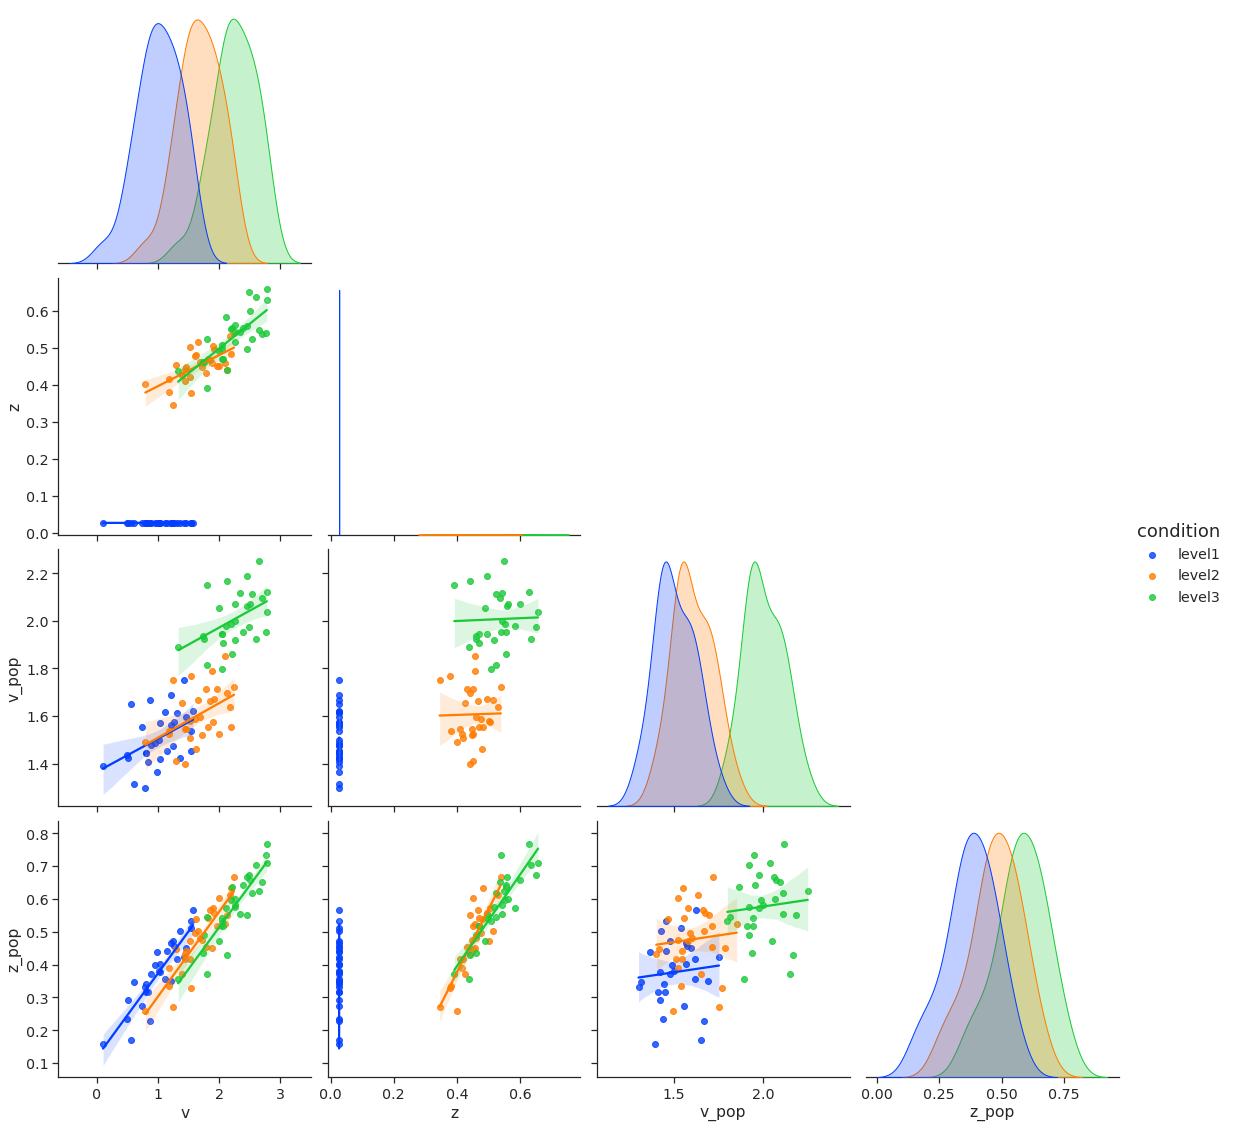

In [37]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright",
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

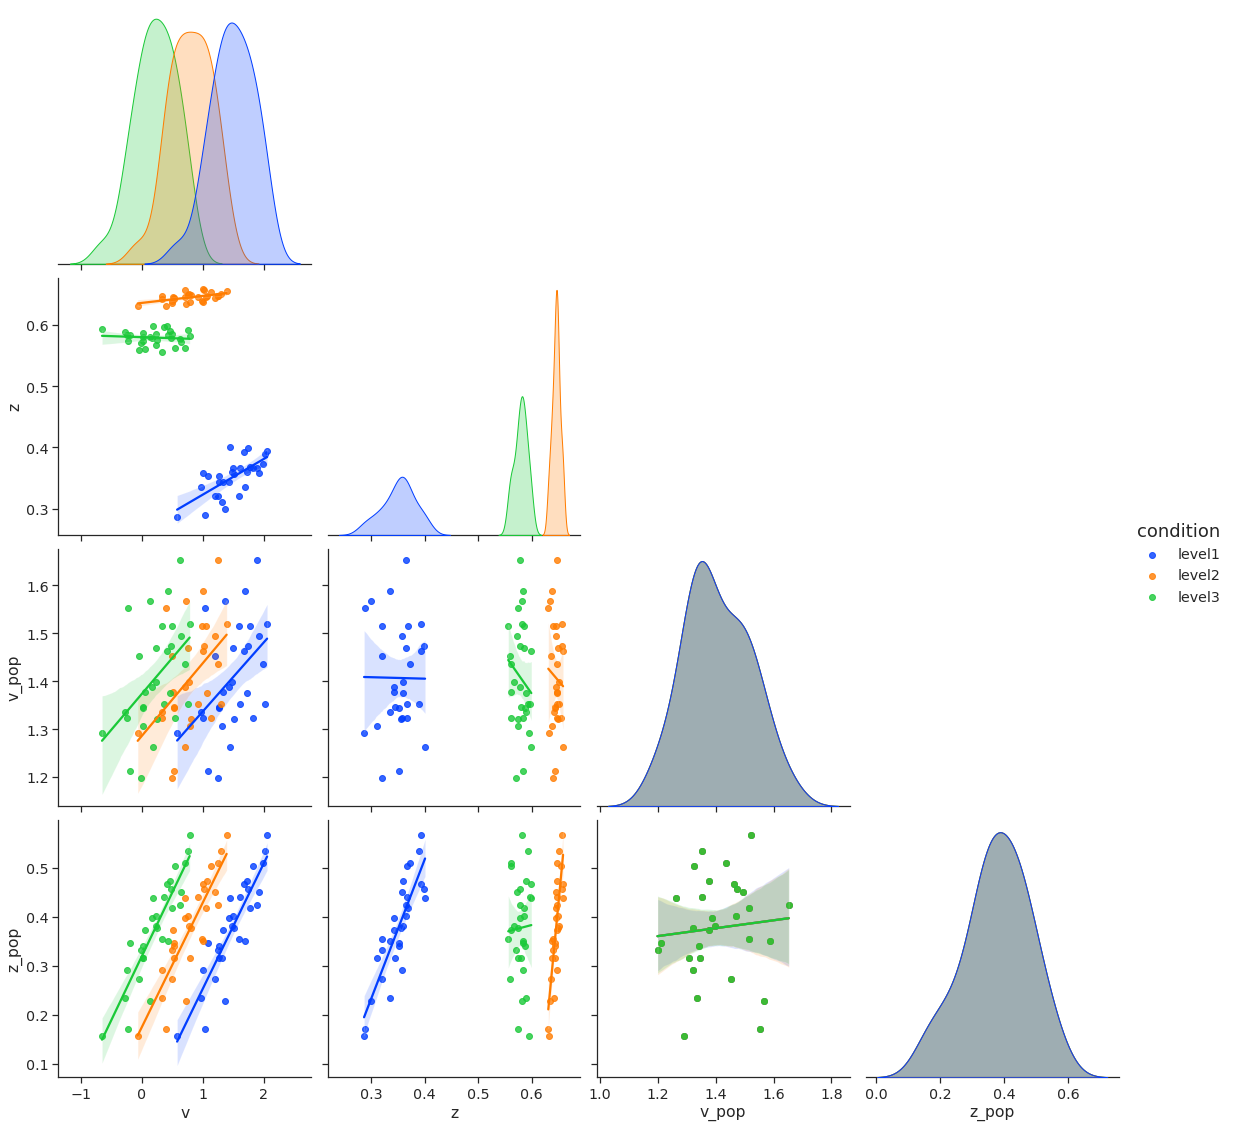

In [39]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

#### M5: Stim-coding + regressor, Way 1
We treat the data as stimulus-coding with within-subject design. 

In [40]:
def z_link_func(x, data=df_stim):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stimulus.loc[x.index]},
                    return_type="dataframe")
#    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                               #{'s':data.stimulus.ix[x.index]})) # original .ix is deprecated.
           )
    #print(x.shape)
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))

And, again, we have two ways to model this situation. 

m5 = hddm:HDDMRegressor{ 'v' ~ levels, 'z' ~ levels, link:lamda invlogit_multiplying_sim}

In [ ]:

# z_reg5 = {'model': "z ~ 1 + C(condition,Treatment('level1'))", 
#          'link_func': z_link_func}

# v_reg5 = {'model': "v ~ 1 + C(condition,Treatment('level1'))", 
#          'link_func': lambda x:x}

# reg_descr5 = [z_reg5, v_reg5]

# m5 = hddm.HDDMRegressor(df_stim, reg_descr5, include='z')

# m5.find_starting_values()

# m5.sample(2000, burn=500, dbname='stim_sim_m5.db', db='pickle') 

# # save the model
# m5.save('stim_sim_m5')
# #stim_sim_m5 = hddm.load('stim_sim_m5')

# m5.print_stats()

#### M6: Stim-coding + regressor, Way 2

Alternatively, we assume the data do not satfifying the model assumption, the pseudo code is like:

m6 = hddm:HDDMRegressor{ 'v' ~ stim * levels, 'z' ~ stim * levels, link:lamda invlogit_multiplying_sim}.

In [41]:
z_reg6 = {'model': "z ~ 0 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': z_link_func}

v_reg6 = {'model': "v ~ 0 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': lambda x:x}

reg_descr6 = [z_reg6, v_reg6]

# need to try group_only_regressors=False ??
m6 = hddm.HDDMRegressor(df_acc, reg_descr6, group_only_regressors=False, keep_regressor_trace=True, include='z')

m6.find_starting_values()

m6.sample(15000, burn=5000, dbname='stim_sim_m6.db', db='pickle') # 20180

# save the model
m6.save('stim_sim_m6')

m6.print_stats()

Adding these covariates:
["z_C(condition, Treatment('level1'))[level1]", "z_C(condition, Treatment('level1'))[level2]", "z_C(condition, Treatment('level1'))[level3]", "z_C(StimType, Treatment('left'))[T.right]", "z_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]", "z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]"]
Adding these covariates:
["v_C(condition, Treatment('level1'))[level1]", "v_C(condition, Treatment('level1'))[level2]", "v_C(condition, Treatment('level1'))[level3]", "v_C(StimType, Treatment('left'))[T.right]", "v_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]", "v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]"]
 [-----------------100%-----------------] 15001 of 15000 complete in 170103.4 secWARNING: Will not save custom link functions.
                                                                                             

In [29]:
#m6 = hddm.load('stim_sim_m6')

In [42]:
m = m6
m_traces = m.get_traces()
m_traces.columns[m_traces.columns.str.contains("v_|z_")]

Index(['z_C(condition, Treatment('level1'))[level1]_trans',
       'z_C(condition, Treatment('level1'))[level1]_std',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.0',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.1',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.2',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.3',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.4',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.5',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.6',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.7',
       ...
       'v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.20',
       'v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.21',
       'v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.22',
       'v_C(condition, 

In [43]:
df_params_ppc = gen_params_comp_reg(m6, df_params)

KeyError: 'v_Intercept_subj.0'

[None, None]

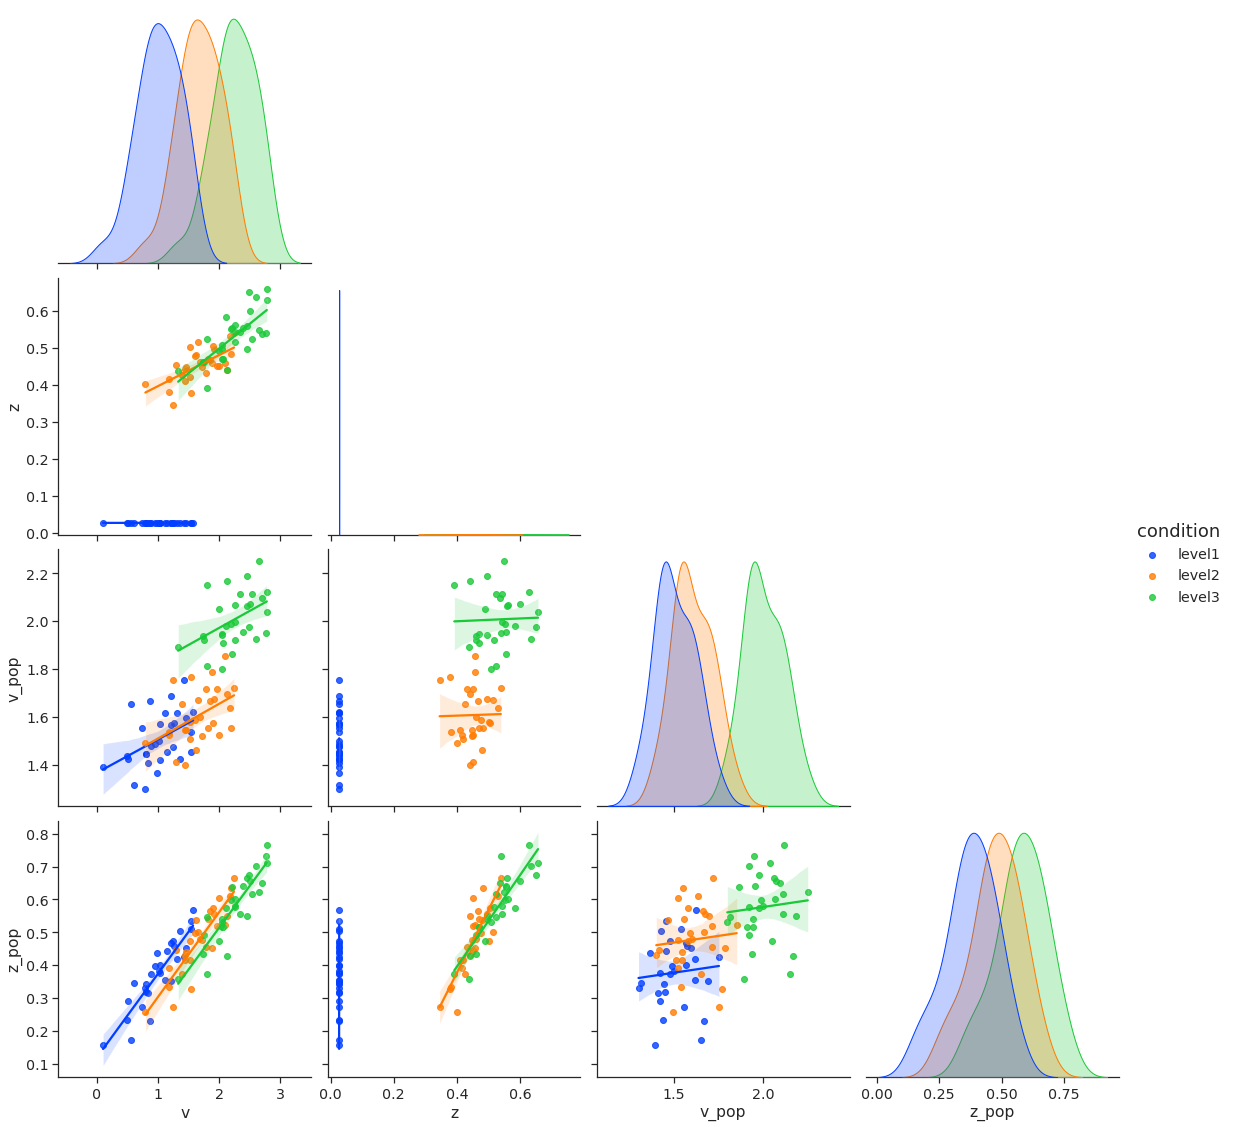

In [44]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

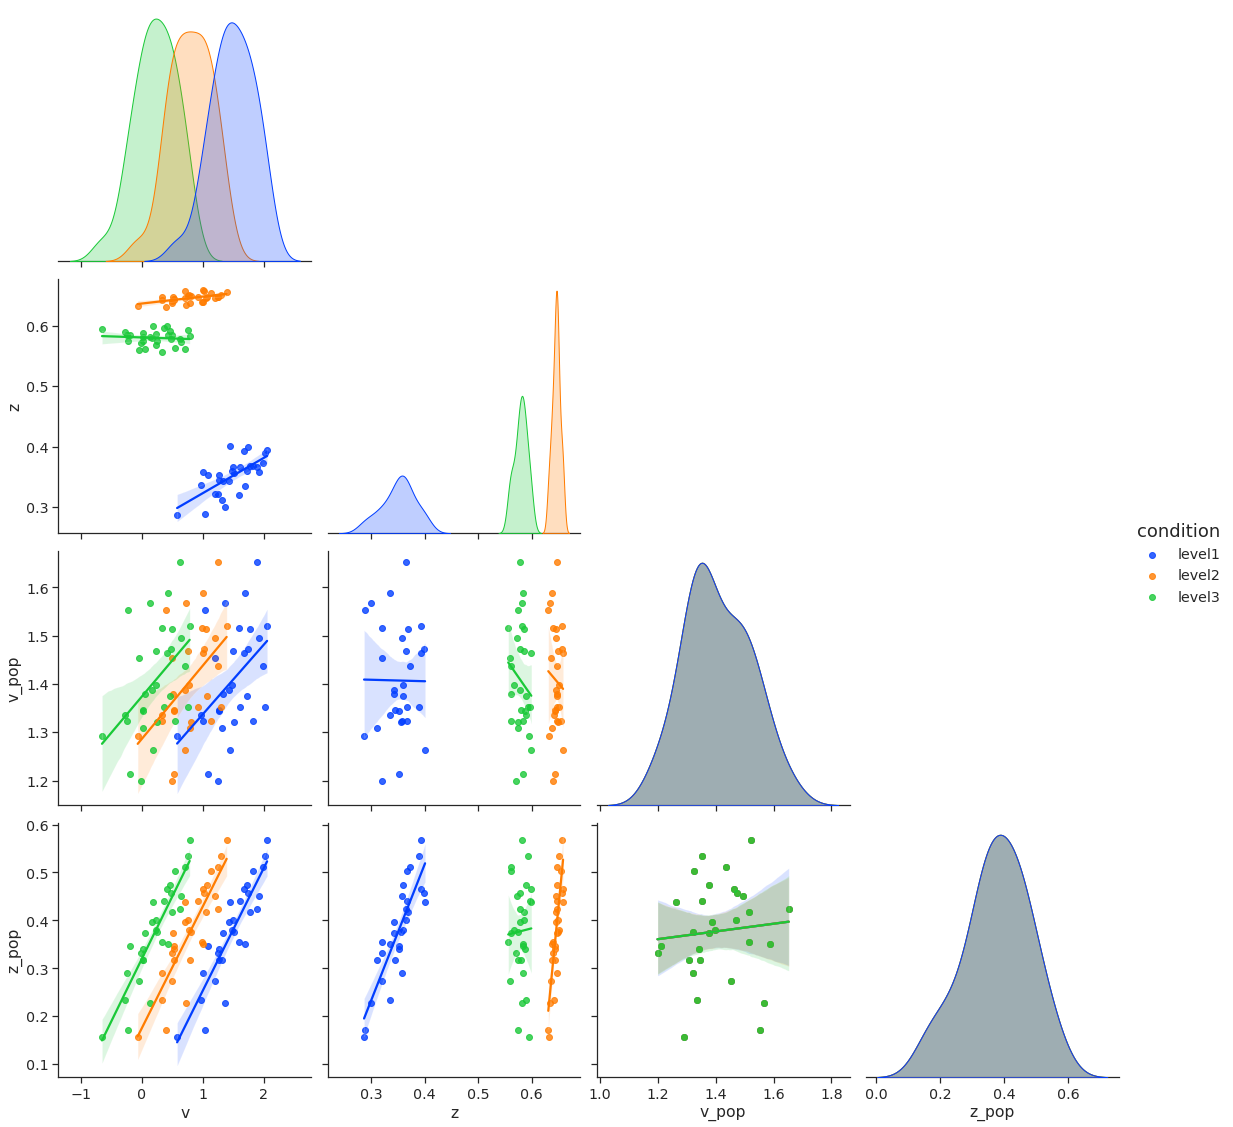

In [45]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

## Let's first replicate the tutorial on HDDM website

http://ski.clps.brown.edu/hddm_docs/tutorial_regression_stimcoding.html

In [ ]:
#import sys
# the following will save all the stdout to the txt file, which is not necessary
# sys.stdout = open('ModelRecoveryOutput.txt', 'w')

### Creating simulated data for  the experiment

set number of subjects and number of trials per level for the simulated experiment

In [ ]:
n_subjects = 15
trials_per_level = 150

Next, set up parameters of the DDM for three levels and the first stimulus. 

In [ ]:
# level1a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
# level2a = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
# level3a = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}

level1a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
level3a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}

Next, set up parameters for the second stimulus, where `v` is the same as for the first stimulus. This is different for `z`. In particular: `z(stimulus_b) = 1 - z(stimulus_a)`. 

In [ ]:
level1b = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2b = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level3b = {'v':.6, 'a':2, 't':.3, 'sv':0, 'z':.3, 'sz':0, 'st':0}

Now, let's generate data for both stimuli

In [ ]:
random.seed(123)
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a},
                                              size=trials_per_level,
                                              subjs=n_subjects)

data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
                                                'level2': level2b,
                                                'level3': level3b},
                                              size=trials_per_level,
                                              subjs=n_subjects)

In [ ]:
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*2, index=data_a.index)
mydata = data_a.append(data_b,ignore_index=True)

In [ ]:
mydata.head(10)

### Setting up the HDDM regression model

The parameter `z` is bound between `0` and `1`, but the standard linear regression does not generate values between `0` and `1`. Therefore, we use a link-function, here the inverse logit $1/(1+exp(-x))$, which transform values between plus and minus infinity into values ranging from (just above) `0` to (nearly) `1`. [this link function is related to logistic regression].

Next, we need to ensure that bias is $z$ for one stimulus and $1-z$ for the other stimulus. To achive this, we can simply multiply the regression output for one stimulus with $-1$. This is implemented here by dot-multiplying the regression output "x" (which is an array) with equally sized array "stim", which is 1 for all stimulus A trials and -1 for stimulus B trials. We use the `patsy` command `dmatrix` to generate such an array from the stimulus column of our stimulated data.

**Note**
* dot-multiplying is vague here, it should be Hadamard Product, see [here](https://www.tutorialexample.com/understand-numpy-np-multiply-np-dot-and-operation-a-beginner-guide-numpy-tutorial/).

In [ ]:
tmpdata = mydata[mydata['subj_idx'] <= 0]
tmpdata

In [ ]:
stim = (dmatrix('0 + C(s, [[1], [-1]])', 
                {'s':tmpdata.stimulus.loc[tmpdata.index]},
                return_type="dataframe")
        )

#tmp = np.multiply(tmpdata[['stimulus']], stim[:])
tmp = np.multiply(tmpdata.stimulus.loc[tmpdata.index].to_frame(),stim)
#1/(1+np.exp(-((np.asarray(mydata.stimulus.iloc[mydata.index])) * stim)))
type(stim)
#stim.index
#type(mydata.stimulus.iloc[mydata.index])

In [ ]:
tmp

In [ ]:
tmp2 = tmpdata.stimulus.loc[tmpdata.index]
tmp2.to_frame().shape

In [ ]:
# x is a pandas Series, it should be converted to dataframe to do the multiplication.

def z_link_func(x, data=mydata):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stimulus.loc[x.index]},
                    return_type="dataframe")
#    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                               #{'s':data.stimulus.ix[x.index]})) # original .ix is deprecated.
           )
    #print(x.shape)
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))
    #return 1 /( 1+np.exp(-(x * stim)))

In [ ]:
# x is a pandas Series, it should be converted to dataframe to do the multiplication.

def v_link_func(x, data=mydata):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stimulus.loc[x.index]},
                    return_type="dataframe")
#    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                               #{'s':data.stimulus.ix[x.index]})) # original .ix is deprecated.
           )
    #print(x.shape)
    return np.multiply(x.to_frame(), stim)
    #return 1 /( 1+np.exp(-(x * stim)))

Now, we set up the regression models for `z` and `v` and also include the link functions. The relevant string here used by `patsy` is `1 + C(condition)`. This will generate a design matrix with an intercept (that's what the `1` is for) and two dummy variables for remaining levels. (The column in which the levels are coded has the default name `condition`):

**NOTE: there is only one variable used in the modelling** 

In [ ]:
z_reg = {'model': 'z ~ 1 + C(condition)', 'link_func':z_link_func}

For `v` the link function is simply $x = x$, b/c no transformation is needed. (However, you could also analyze this experiment with response coded data. Then you would not stimulus code `z` but `v` and you would have to multiply the `v` for one condition with `-1`, with a link function like the one for `z`, but without the additional logit transform):

In [ ]:
v_reg = {'model': 'v ~ 1 + C(condition)', 'link_func': lambda x:x}

Now, we can finally put the regression description for the hddm model together. The general for this is `[{'model': 'outcome_parameter ~ patsy_design_string', 'link_func': your_link_func}, {...}, ...]`

In [ ]:
reg_descr = [z_reg, v_reg]

The last step before running the model is to construct the complete hddm regression model by adding data etc.

In [ ]:
m_reg = hddm.HDDMRegressor(mydata, reg_descr, include='z')

Now, we start the sampling, which takes a long time

In [ ]:
m_reg.sample(1000, burn=200, dbname='within_effect.db', db='pickle') 

In [ ]:
m_reg.save('within_effect')

In [ ]:
m_reg.plot_posteriors()

In [ ]:
m_reg.print_stats()

In [ ]:
v_reg2 = {'model': 'v ~ 1 + C(condition)', 'link_func': v_link_func}

In [ ]:
reg_descr2 = [z_reg, v_reg2]
m_reg2 = hddm.HDDMRegressor(mydata, reg_descr2, include='z')
m_reg2.sample(1000, burn=200, dbname='within_effect2.db', db='pickle') 
m_reg2.save('within_effect2')

In [ ]:
m_reg2.print_stats()

**What if we model as I did?**

First, add the reponse type as an other variable

In [ ]:
mydata2 = mydata
# df.loc[df['salary'] > 50, 'is_rich'] = 'yes'
# https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# df['hasimage'] = np.where(df['photos']!= '[]', True, False) 
mydata2['StimType'] = np.where(mydata2['stimulus'] == 1.0, 'left', 'right')
# mydata2.loc[mydata2['stimulus'] == 0,'StimType'] = 'right'

In [ ]:
mydata2.head(10)

In [ ]:
z_reg2 = {'model': "z ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 'link_func':z_link_func}
v_reg2 = {'model': "v ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 'link_func': lambda x:x}
reg_descr2 = [z_reg2, v_reg2]

In [ ]:
# check the design matrix
dmatrix("C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
        {'condition':mydata2['condition'], 'StimType':mydata2['StimType']})


In [ ]:
m_reg2 = hddm.HDDMRegressor(mydata2, reg_descr2, include='z')

In [ ]:
m_reg2.sample(1000, burn=200, dbname='within_effect2.db', db='pickle') 
m_reg2.save('within_effect2')
m_reg2.plot_posteriors()

In [ ]:
m_reg2 = hddm.load("within_effect2")

In [ ]:
m_reg2_trace = m_reg2.get_group_traces()
print(m_reg2_trace.shape)
m_reg2_trace.head(10)

In [ ]:
# rename the columns
import re

lst = ["v_", "z_", "t(", 'cha']
esc_lst = [re.escape(s) for s in lst]
pattern = '|'.join(esc_lst)

# select v, a, t, and chains
slct_columns = m_reg2_trace.columns[m_reg2_trace.columns.str.contains(pattern, case=False)]

slct_columns = [ x for x in slct_columns if "std" not in x ]

df_tmp = m_reg2_trace[slct_columns]
df_tmp.head(10)

In [ ]:
df_tmp.columns = ['z_intercept', 'z_effect_L2', 'z_effect_L3', 'z_effect_left', 'z_L2:left', 'z_L3:left',
                  'v_intercept', 'v_effect_L2', 'v_effect_L3', 'v_effect_left', 'v_L2:left', 'v_L3:left'] 
df_tmp.head(10)

In [ ]:
df_tmp.loc[:,'v_L1_left'] = df_tmp.loc[:,'v_intercept'].copy()
df_tmp.loc[:,'v_L2_left']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_L2'].copy()
df_tmp.loc[:,'v_L3_left'] = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_L3'].copy()
df_tmp.loc[:,'v_L1_right']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_left'].copy()
df_tmp.loc[:,'v_L2_right']   = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_left'].copy() + df_tmp.loc[:, 'v_L2:left'].copy()
df_tmp.loc[:,'v_L3_right']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_left'].copy() + df_tmp.loc[:, 'v_L3:left'].copy()


In [ ]:
df_tmp.head()

In [ ]:
df_tmp_v = df_tmp[['v_L1_left', 'v_L2_left', 'v_L3_left', 'v_L1_right', 'v_L2_right', 'v_L3_right']]
df_tmp_v.head(10)

In [ ]:
df_tmp_v.plot.density(figsize=(8,6),xlim=(-2.5, 3.5),linewidth=3)

### Comparing generative and recovered model parameters
First, let's print the model stats

In [ ]:
m_reg.print_stats()

## Working with real data

Now let's move to the real data. 

I will use 1b as the example because it includes many scale data. I'd like to try whether we can add these scores as an group-level predictor.


I will first model the data as the tutorial about within-subject design and stimulus-coding, then I will add the self-esteem as an additional regressor.

In [ ]:
# load data
df1b = hddm.load_csv('df1bv.hddm_stim.reg.csv')
df = df1b

# randomly chose 10 participants from the dataset
df_subj = df['subj_idx'].unique()
random.seed(10)
df_test_list = []
for i in range(10):
    pos = random.randint(0, (len(df_subj)-1))
    df_test_list.append(df_subj[pos])  

df_test = df[df['subj_idx'].isin(df_test_list)]

In [ ]:
df_test.head(10)

In [ ]:
# create a link func for z
def z_link_func(x, data=df_test):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stim.loc[x.index]},
                    return_type="dataframe")
           )
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))

### Stimulus coding in regressor

This time, explicitly used `C` to indicate the independent variables are categorical.

In [ ]:
z_reg = {'model': "z ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': z_link_func}

In [ ]:
# check the design matrix
# without self-esteem as a regressor
dmatrix("C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", {'match':df_test['match'], 'val':df_test['val']})

# with self-esteem as regressor
#dmatrix("SlfEst_sum:C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", {'SlfEst_sum':df_test['SlfEst_sum'], 'match':df_test['match'], 'val':df_test['val']})

In [ ]:
z_reg = {'model': "z ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': z_link_func}
v_reg = {'model': "v ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': lambda x:x}
a_reg = {'model': "a ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': lambda x:x}

reg_descr = [z_reg, v_reg, a_reg]

m_reg = hddm.HDDMRegressor(df_test, v_reg, include='z')

In [ ]:
start_time = time.time()   # the start time of the processing

m_reg.sample(5000, burn=1000, dbname='df1_within_effect_try.db', db='pickle') 

print("\nRunning within model of exp 1a (10 subj) used: %f seconds" % (time.time() - start_time)) # print the elapse of time

In [ ]:
m_reg.save('df1_within_effect_try')

In [ ]:
m_reg.plot_posteriors()

In [ ]:
print("m_reg DIC: %f" % m_reg.dic) 

In [ ]:
stats = m_reg.gen_stats()
stats

In [ ]:
v_nmn, v_nmg, v_nmb = m_reg.nodes_db.loc[["v_Intercept",
                                              "v_C(val, Treatment('Neutral'))[T.Bad]",
                                              "v_C(val, Treatment('Neutral'))[T.Good]"], 'node']
#v_nmg = v_nmn + v_nmg
#v_nmb = v_nmn + v_nmb
hddm.analyze.plot_posterior_nodes([v_nmn, v_nmg, v_nmb])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [ ]:
v_mn, v_mg, v_mb = m_reg.nodes_db.loc[["v_C(match, Treatment('Mismatch'))[T.Match]",
                                              "v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Bad]",
                                              "v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Good]"], 'node']
#v_nmg = v_nmn + v_nmg
#v_nmb = v_nmn + v_nmb
hddm.analyze.plot_posterior_nodes([v_mn, v_mg, v_mb])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [ ]:
m_reg_trace = m_reg.get_group_traces()
print(m_reg_trace.shape)

In [ ]:
m_reg_trace.head(10)

In [ ]:
# rename the columns
import re

lst = ["v_", "a(", "t(", 'cha']
esc_lst = [re.escape(s) for s in lst]
pattern = '|'.join(esc_lst)

# select v, a, t, and chains
slct_columns = m_reg_trace.columns[m_reg_trace.columns.str.contains(pattern, case=False)]

slct_columns = [ x for x in slct_columns if "std" not in x ]

df_tmp = m_reg_trace[slct_columns]
df_tmp.head(10)

In [ ]:
df_tmp.columns = ['v_intercept', 'v_effect_Match', 'v_effect_NM_Bad', 'v_effect_NM_Good', 'v_Match:Bad', 'v_Match:Good'] 
df_tmp.head(10)

In [ ]:
df_tmp.loc[:,'NM_Neut'] = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Bad'].copy()

In [ ]:
df_tmp.loc[:,'NM_Neut'] = df_tmp.loc[:,'v_intercept'].copy()
df_tmp.loc[:,'NM_Bad']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Bad'].copy()
df_tmp.loc[:,'NM_Good'] = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Good'].copy()
df_tmp.loc[:,'M_Neut']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy()
df_tmp.loc[:,'M_Bad']   = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy() + df_tmp.loc[:, 'v_Match:Bad'].copy()
df_tmp.loc[:,'M_Good']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy() + df_tmp.loc[:, 'v_Match:Good'].copy()


In [ ]:
df_tmp = df_tmp.loc[:, ['NM_Neut', 'NM_Bad', 'NM_Good', 'M_Neut', 'M_Bad', 'M_Good']]
df_tmp.head(10)

In [ ]:
df_tmp.plot.density(figsize=(8,6),xlim=(-2.5, 3.5),linewidth=3)

In [ ]:


df_tmp["id"] = df_tmp.index
# df_tmp.head()
print('Shape of the wide format', df_tmp.shape)

df_melt = pd.melt(df_tmp,
                  id_vars=['id'],
                  value_vars=['NM_Neut', 'NM_Bad', 'NM_Good', 'M_Neut', 'M_Bad', 'M_Good'],
                  var_name='cond',
                  value_name='value')

#type(df_melt)
print('Shape of the long format', df_melt.shape)
df_melt.head()

In [ ]:
# split the cond column into three columns
df_melt[['Matchness','Valence']] = pd.DataFrame(df_melt['cond'].apply(lambda x: [i for i in re.split(r'[\_\.]', x) if len(i)>0]).to_list())
df_melt.head()

In [ ]:
df_melt['cond_c'] = pd.Categorical(df_melt['cond'], categories=['NM_Bad', 'NM_Neut', 'NM_Good', 'M_Bad', 'M_Neut',  'M_Good'])

import seaborn as sns
sns.kdeplot(data=df_melt, x="value", hue="cond_c")